# A Modelling, Simulation and Optimisation Solution for HS2 High Speed Rail Service

                                             Emmanuel Adekola

## Table of Contents
1. [Load Project Description](#1-bullet)<br>
2. [Install Libraries for Modelling, Simulation and Optimization](#2-bullet)<br>
3. [Import Libraries for Modelling, Simulation and Optimization](#3-bullet)<br>
4. [Define and Load Dataframe](#4-bullet)<br>
5. [Define Time Conversion Method](#5-bullet)<br>
6. [Simulation Model](#6-bullet)<br>
    6.1 [Creating Simulation Function](#6A-bullet)<br>
    6.2 [Defining Simulation Criteria](#6B-bullet)<br>
    6.3 [Simulation Result](#6C-bullet)<br>
7. [Optimization Model](#7-bullet)<br>
    7.1 [Minimizing the Overall Average Traveling Time](#7A-bullet)<br>
    7.2 [Poisson-Distribution; Maximising the throughput of passengers in peak hours](#7B-bullet)<br>
8. [References](#8-bullet)<br>

## Load Project Description <a class="anchor" id="1-bullet"></a>

In [1]:
#Open the project description for easy reading/reference

#import necessary libraries
from IPython.display import IFrame, display
#Define filepath
filepath = "https://moodle.ncirl.ie/pluginfile.php/335590/mod_resource/content/0/H9MSO%20Project%20Outline.pdf" # works with websites too!
#display(IFrame(rel_report_path, width=800, height=400))
display(IFrame(filepath, width=1000, height=400))

## Install Libraries for Modelling, Simulation and Optimization <a class="anchor" id="2-bullet"></a>

In [2]:
#install recommended libraries
!pip install simpy
!pip install pint

## Import Libraries for Modelling, Simulation and Optimization <a class="anchor" id="2-bullet"></a>

In [3]:
#Import necessary libraries for MSO
import numpy as np
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt
import random 
import math
import scipy as sp
import scipy.stats as stats
import statsmodels.api as sm
import simpy
import simpy.events as evt

## Define and Load Dataframe <a class="anchor" id="2-bullet"></a>

In [4]:
#Define, create and load data frame based on project requirement
HS2Data={'Line':['HS2', 'HS2', 'HS2'], 'From':['London Euston', 'London Old Oak Common', 'Birmingham Interchange'], 
        'To': ['London Old Oak Common', 'Birmingham Interchange', 'Birmingham Curzon Street'], 'Distance': [23.4, 145, 42.1],
        'Running Time': [5,31,9], 'Signal Blocks': [1,14,2], 'Delay': [300,300,300], 'DwellTime': [60,60,60]}

#Create data frame
dt = pd.DataFrame(HS2Data)

#Convert distances to meters and time to seconds
dt['Distance']=dt['Distance'].apply(lambda x: int(x*1000))
dt['Running Time']=dt['Running Time'].apply(lambda x: int(x*60))

#Display data frame for review
dt

,Line,From,To,Distance,Running Time,Signal Blocks,Delay,DwellTime
0,HS2,London Euston,London Old Oak Common,23400,300,1,300,60
1,HS2,London Old Oak Common,Birmingham Interchange,145000,1860,14,300,60
2,HS2,Birmingham Interchange,Birmingham Curzon Street,42100,540,2,300,60


## Define Time Conversion Method <a class="anchor" id="5-bullet"></a>

In [5]:
#Method to convert time into seconds
def parseTime(s):
    if isinstance(s, str):
        parts=s.split(':')
        if len(parts)>=2:
            hours=int(parts[0])
            minutes=int(parts[1])
            seconds=0 if len(parts)==2 else int(parts[2])
            return 3600*hours+60*minutes+seconds
    # any wrong formats will be passed through and may cause an error at a later stage
    return s

## Simulation Model <a class="anchor" id="6-bullet"></a>
Creating a simulation for the London-Birmingham section. A decision on the number of signaling blocks
and a decision on the number of trains running per hour was made.<br>

### Creating Simulation Function <a class="anchor" id="6A-bullet"></a>
Creating a simulation class for the London-Birmingham section

In [6]:
# Define the train movement process
class Train(object): 
    def __init__(self, env, that):
        self.env = env
        self.that = that;

    def logTrainSchedule(self):
        pass

    def process(self, train_no, wait_time):
        """ Train Process, {delay=60} we assume train will stop for a minute in every station."""

        train_name = '[Train Number - '+f"{train_no:2d}"+']'
        here = self.that.stations()[0]       
        index = 0
        for station in self.that.stations()[1:]:
            data=dt[dt['From']==here]
            runTime=data.iloc[0].at['Running Time']
            no_of_block = data.iloc[0].at['Signal Blocks']
            drive = runTime/no_of_block
            if wait_time:
                print(f"{self.that.currentTime():s} waiting....")
                yield self.env.timeout(wait_time)
                print(f"{self.that.currentTime():s} Resume....")

            print(f"{self.that.currentTime():s} {train_name:s} dep {here:s} for {station:s}")

            for sig in self.that.blocks()[index]:
                with sig.request() as req:
                    yield req        
                    yield self.env.timeout(drive)                  
                    here=station                  
                    print(f"{self.that.currentTime():s} {train_name:s} arr {here:s}")
            index+=1

### Defining Simulation Criteria<a class="anchor" id="6B-bullet"></a>
Simulating the throughput of trains based on the number of signalling blocks and other set requirements

In [7]:
#Criteria definition (stations and signalling blocks), Utility function formatting date and time, and defining Simulation method
class Network(object):
    def __init__(self, start, end, interval, train_count, wait_time):
        self.start = parseTime(start)
        self.stop = parseTime(end)
        self.interval = interval
        self.env=simpy.Environment()
        self.train = Train(self.env, self)
        self.t_count = train_count
        self.w_time = wait_time

    def stations(self):
        """ Station name from list. """
        stations=dt['From'].tolist()
        stations+=[dt['To'].tolist() [-1]]
        return stations    

    def formattedSystemTime(self, time):
        time=int(time)
        return f"{time//3600:02d}:{(time%3600)//60:02d}:{time%60:02d}"

    def currentTime(self):
        return self.formattedSystemTime(self.env.now)
    
    def updateSignalCount(self, count):
        dt['Signal Blocks'][1] = count

    def incident(self, wait_time):
        """" Wait time """
        if wait_time:
            return wait_time
        else:
            return 0

    def trainCount(self, train_count):
        if train_count:
            return train_count
        else:
            return int((self.stop-self.start)/self.interval)

    def process(self): 
        """ Start train simulation process"""     
        yield self.env.timeout(self.start-self.env.now) 
        for train_no in range(self.trainCount(self.t_count)):          
            self.env.process(self.train.process(train_no, self.incident(self.w_time)))
            yield self.env.timeout(self.interval)

    def blocks(self):
        """ Signaling blocks between stations"""
        blocks_list = []
        here = self.stations()[0]

        for dest in self.stations()[1:]:
            dest_blocks = []
            desRow = dt[dt['From'] == here]
            no_of_blocks = desRow.iloc[0].at['Signal Blocks']
            for i in range(no_of_blocks):
                b = simpy.Resource(self.env, capacity=1)
                dest_blocks.append(b)

            blocks_list.append(dest_blocks)
            here=dest
        return blocks_list

    def runSimulation(self):
        """ starting process. """
        self.env.process(self.process())
        self.env.run()

## Simulation Result <a class="anchor" id="6C-bullet"></a>

In [8]:
#Verifying the system; running Simulation
trainetwork=Network("06:00", "07:00", 180, None, None)
trainetwork.runSimulation()
dt

06:00:00 [Train Number -  0] dep London Euston for London Old Oak Common
06:03:00 [Train Number -  1] dep London Euston for London Old Oak Common
06:05:00 [Train Number -  0] arr London Old Oak Common
06:05:00 [Train Number -  0] dep London Old Oak Common for Birmingham Interchange
06:06:00 [Train Number -  2] dep London Euston for London Old Oak Common
06:07:12 [Train Number -  0] arr Birmingham Interchange
06:08:00 [Train Number -  1] arr London Old Oak Common
06:08:00 [Train Number -  1] dep London Old Oak Common for Birmingham Interchange
06:09:00 [Train Number -  3] dep London Euston for London Old Oak Common
06:09:25 [Train Number -  0] arr Birmingham Interchange
06:10:12 [Train Number -  1] arr Birmingham Interchange
06:11:00 [Train Number -  2] arr London Old Oak Common
06:11:00 [Train Number -  2] dep London Old Oak Common for Birmingham Interchange
06:11:38 [Train Number -  0] arr Birmingham Interchange
06:12:00 [Train Number -  4] dep London Euston for London Old Oak Common


06:41:00 [Train Number - 12] dep London Old Oak Common for Birmingham Interchange
06:41:21 [Train Number -  4] arr Birmingham Interchange
06:41:29 [Train Number -  7] arr Birmingham Interchange
06:41:38 [Train Number - 10] arr Birmingham Interchange
06:41:59 [Train Number -  2] arr Birmingham Interchange
06:41:59 [Train Number -  2] dep Birmingham Interchange for Birmingham Curzon Street
06:42:00 [Train Number - 14] dep London Euston for London Old Oak Common
06:42:08 [Train Number -  5] arr Birmingham Interchange
06:42:17 [Train Number -  8] arr Birmingham Interchange
06:42:25 [Train Number - 11] arr Birmingham Interchange
06:42:47 [Train Number -  3] arr Birmingham Interchange
06:42:55 [Train Number -  6] arr Birmingham Interchange
06:43:04 [Train Number -  9] arr Birmingham Interchange
06:43:12 [Train Number - 12] arr Birmingham Interchange
06:43:29 [Train Number -  1] arr Birmingham Curzon Street
06:43:34 [Train Number -  4] arr Birmingham Interchange
06:43:42 [Train Number -  7] a

07:29:59 [Train Number - 18] dep Birmingham Interchange for Birmingham Curzon Street
07:30:47 [Train Number - 19] arr Birmingham Interchange
07:31:29 [Train Number - 17] arr Birmingham Curzon Street
07:32:59 [Train Number - 16] arr Birmingham Curzon Street
07:32:59 [Train Number - 19] arr Birmingham Interchange
07:32:59 [Train Number - 19] dep Birmingham Interchange for Birmingham Curzon Street
07:34:29 [Train Number - 18] arr Birmingham Curzon Street
07:35:59 [Train Number - 17] arr Birmingham Curzon Street
07:37:29 [Train Number - 19] arr Birmingham Curzon Street
07:38:59 [Train Number - 18] arr Birmingham Curzon Street
07:41:59 [Train Number - 19] arr Birmingham Curzon Street


,Line,From,To,Distance,Running Time,Signal Blocks,Delay,DwellTime
0,HS2,London Euston,London Old Oak Common,23400,300,1,300,60
1,HS2,London Old Oak Common,Birmingham Interchange,145000,1860,14,300,60
2,HS2,Birmingham Interchange,Birmingham Curzon Street,42100,540,2,300,60


## Optimization Model <a class="anchor" id="7-bullet"></a>
Creating a simulation of the train network for the
given train schedule (numbers of trains per hour n ∈ {1, 2, 3, 4, 5, 6, 8, 10, 12, 15, 20}) and a
given break-down of the line in signalling blocks k ∈ {1, ..., 15} a distribution of average
overall travelling time.

In [9]:
#Optimization
def simulateBlockWithTrain():
    train_per_hour = [20] 
  
    for train_count in train_per_hour:     
        for signal_count in range(1, 15):  
            network=Network("06:00", "07:00", 180, train_count, None)
            network.updateSignalCount(signal_count)
            network.runSimulation()

In [10]:
#Simulation output
simulateBlockWithTrain()

C:\Users\Popeoba\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


06:00:00 [Train Number -  0] dep London Euston for London Old Oak Common
06:03:00 [Train Number -  1] dep London Euston for London Old Oak Common
06:05:00 [Train Number -  0] arr London Old Oak Common
06:05:00 [Train Number -  0] dep London Old Oak Common for Birmingham Interchange
06:06:00 [Train Number -  2] dep London Euston for London Old Oak Common
06:08:00 [Train Number -  1] arr London Old Oak Common
06:08:00 [Train Number -  1] dep London Old Oak Common for Birmingham Interchange
06:09:00 [Train Number -  3] dep London Euston for London Old Oak Common
06:11:00 [Train Number -  2] arr London Old Oak Common
06:11:00 [Train Number -  2] dep London Old Oak Common for Birmingham Interchange
06:12:00 [Train Number -  4] dep London Euston for London Old Oak Common
06:14:00 [Train Number -  3] arr London Old Oak Common
06:14:00 [Train Number -  3] dep London Old Oak Common for Birmingham Interchange
06:15:00 [Train Number -  5] dep London Euston for London Old Oak Common
06:17:00 [Trai

07:30:00 [Train Number - 15] arr Birmingham Curzon Street
07:31:30 [Train Number - 17] arr Birmingham Curzon Street
07:33:00 [Train Number - 19] arr Birmingham Interchange
07:33:00 [Train Number - 19] dep Birmingham Interchange for Birmingham Curzon Street
07:33:00 [Train Number - 16] arr Birmingham Curzon Street
07:34:30 [Train Number - 18] arr Birmingham Curzon Street
07:36:00 [Train Number - 17] arr Birmingham Curzon Street
07:37:30 [Train Number - 19] arr Birmingham Curzon Street
07:39:00 [Train Number - 18] arr Birmingham Curzon Street
07:42:00 [Train Number - 19] arr Birmingham Curzon Street
06:00:00 [Train Number -  0] dep London Euston for London Old Oak Common
06:03:00 [Train Number -  1] dep London Euston for London Old Oak Common
06:05:00 [Train Number -  0] arr London Old Oak Common
06:05:00 [Train Number -  0] dep London Old Oak Common for Birmingham Interchange
06:06:00 [Train Number -  2] dep London Euston for London Old Oak Common
06:08:00 [Train Number -  1] arr London

06:03:00 [Train Number -  1] dep London Euston for London Old Oak Common
06:05:00 [Train Number -  0] arr London Old Oak Common
06:05:00 [Train Number -  0] dep London Old Oak Common for Birmingham Interchange
06:06:00 [Train Number -  2] dep London Euston for London Old Oak Common
06:08:00 [Train Number -  1] arr London Old Oak Common
06:08:00 [Train Number -  1] dep London Old Oak Common for Birmingham Interchange
06:09:00 [Train Number -  3] dep London Euston for London Old Oak Common
06:11:00 [Train Number -  2] arr London Old Oak Common
06:11:00 [Train Number -  2] dep London Old Oak Common for Birmingham Interchange
06:12:00 [Train Number -  4] dep London Euston for London Old Oak Common
06:14:00 [Train Number -  3] arr London Old Oak Common
06:14:00 [Train Number -  3] dep London Old Oak Common for Birmingham Interchange
06:15:00 [Train Number -  5] dep London Euston for London Old Oak Common
06:15:20 [Train Number -  0] arr Birmingham Interchange
06:17:00 [Train Number -  4] ar

07:30:00 [Train Number - 15] arr Birmingham Curzon Street
07:31:30 [Train Number - 17] arr Birmingham Curzon Street
07:33:00 [Train Number - 19] arr Birmingham Interchange
07:33:00 [Train Number - 19] dep Birmingham Interchange for Birmingham Curzon Street
07:33:00 [Train Number - 16] arr Birmingham Curzon Street
07:34:30 [Train Number - 18] arr Birmingham Curzon Street
07:36:00 [Train Number - 17] arr Birmingham Curzon Street
07:37:30 [Train Number - 19] arr Birmingham Curzon Street
07:39:00 [Train Number - 18] arr Birmingham Curzon Street
07:42:00 [Train Number - 19] arr Birmingham Curzon Street
06:00:00 [Train Number -  0] dep London Euston for London Old Oak Common
06:03:00 [Train Number -  1] dep London Euston for London Old Oak Common
06:05:00 [Train Number -  0] arr London Old Oak Common
06:05:00 [Train Number -  0] dep London Old Oak Common for Birmingham Interchange
06:06:00 [Train Number -  2] dep London Euston for London Old Oak Common
06:08:00 [Train Number -  1] arr London

06:24:00 [Train Number -  8] dep London Euston for London Old Oak Common
06:26:00 [Train Number -  7] arr London Old Oak Common
06:26:00 [Train Number -  7] dep London Old Oak Common for Birmingham Interchange
06:26:12 [Train Number -  5] arr Birmingham Interchange
06:26:24 [Train Number -  3] arr Birmingham Interchange
06:26:36 [Train Number -  1] arr Birmingham Interchange
06:27:00 [Train Number -  9] dep London Euston for London Old Oak Common
06:29:00 [Train Number -  8] arr London Old Oak Common
06:29:00 [Train Number -  8] dep London Old Oak Common for Birmingham Interchange
06:29:12 [Train Number -  6] arr Birmingham Interchange
06:29:24 [Train Number -  4] arr Birmingham Interchange
06:29:36 [Train Number -  2] arr Birmingham Interchange
06:29:48 [Train Number -  0] arr Birmingham Interchange
06:30:00 [Train Number - 10] dep London Euston for London Old Oak Common
06:32:00 [Train Number -  9] arr London Old Oak Common
06:32:00 [Train Number -  9] dep London Old Oak Common for B

07:09:00 [Train Number - 11] dep Birmingham Interchange for Birmingham Curzon Street
07:09:00 [Train Number -  8] arr Birmingham Curzon Street
07:10:30 [Train Number - 10] arr Birmingham Curzon Street
07:11:24 [Train Number - 18] arr Birmingham Interchange
07:11:36 [Train Number - 16] arr Birmingham Interchange
07:11:48 [Train Number - 14] arr Birmingham Interchange
07:12:00 [Train Number - 12] arr Birmingham Interchange
07:12:00 [Train Number - 12] dep Birmingham Interchange for Birmingham Curzon Street
07:12:00 [Train Number -  9] arr Birmingham Curzon Street
07:13:30 [Train Number - 11] arr Birmingham Curzon Street
07:14:24 [Train Number - 19] arr Birmingham Interchange
07:14:36 [Train Number - 17] arr Birmingham Interchange
07:14:48 [Train Number - 15] arr Birmingham Interchange
07:15:00 [Train Number - 13] arr Birmingham Interchange
07:15:00 [Train Number - 13] dep Birmingham Interchange for Birmingham Curzon Street
07:15:00 [Train Number - 10] arr Birmingham Curzon Street
07:16:3

06:42:20 [Train Number -  9] arr Birmingham Interchange
06:42:50 [Train Number -  4] arr Birmingham Interchange
06:43:10 [Train Number - 11] arr Birmingham Interchange
06:43:30 [Train Number -  1] arr Birmingham Curzon Street
06:43:40 [Train Number -  6] arr Birmingham Interchange
06:44:00 [Train Number - 13] arr London Old Oak Common
06:44:00 [Train Number - 13] dep London Old Oak Common for Birmingham Interchange
06:44:30 [Train Number -  8] arr Birmingham Interchange
06:45:00 [Train Number -  3] arr Birmingham Interchange
06:45:00 [Train Number -  3] dep Birmingham Interchange for Birmingham Curzon Street
06:45:00 [Train Number -  0] arr Birmingham Curzon Street
06:45:00 [Train Number - 15] dep London Euston for London Old Oak Common
06:45:20 [Train Number - 10] arr Birmingham Interchange
06:45:50 [Train Number -  5] arr Birmingham Interchange
06:46:10 [Train Number - 12] arr Birmingham Interchange
06:46:30 [Train Number -  2] arr Birmingham Curzon Street
06:46:40 [Train Number -  7

06:24:00 [Train Number -  8] dep London Euston for London Old Oak Common
06:24:17 [Train Number -  2] arr Birmingham Interchange
06:24:25 [Train Number -  5] arr Birmingham Interchange
06:25:42 [Train Number -  1] arr Birmingham Interchange
06:25:51 [Train Number -  4] arr Birmingham Interchange
06:26:00 [Train Number -  7] arr London Old Oak Common
06:26:00 [Train Number -  7] dep London Old Oak Common for Birmingham Interchange
06:27:00 [Train Number -  9] dep London Euston for London Old Oak Common
06:27:08 [Train Number -  0] arr Birmingham Interchange
06:27:17 [Train Number -  3] arr Birmingham Interchange
06:27:25 [Train Number -  6] arr Birmingham Interchange
06:28:42 [Train Number -  2] arr Birmingham Interchange
06:28:51 [Train Number -  5] arr Birmingham Interchange
06:29:00 [Train Number -  8] arr London Old Oak Common
06:29:00 [Train Number -  8] dep London Old Oak Common for Birmingham Interchange
06:30:00 [Train Number - 10] dep London Euston for London Old Oak Common
06:

06:24:00 [Train Number -  8] dep London Euston for London Old Oak Common
06:24:22 [Train Number -  0] arr Birmingham Interchange
06:24:45 [Train Number -  4] arr Birmingham Interchange
06:25:37 [Train Number -  3] arr Birmingham Interchange
06:26:00 [Train Number -  7] arr London Old Oak Common
06:26:00 [Train Number -  7] dep London Old Oak Common for Birmingham Interchange
06:26:30 [Train Number -  2] arr Birmingham Interchange
06:26:52 [Train Number -  6] arr Birmingham Interchange
06:27:00 [Train Number -  9] dep London Euston for London Old Oak Common
06:27:22 [Train Number -  1] arr Birmingham Interchange
06:27:45 [Train Number -  5] arr Birmingham Interchange
06:28:15 [Train Number -  0] arr Birmingham Interchange
06:28:37 [Train Number -  4] arr Birmingham Interchange
06:29:00 [Train Number -  8] arr London Old Oak Common
06:29:00 [Train Number -  8] dep London Old Oak Common for Birmingham Interchange
06:29:30 [Train Number -  3] arr Birmingham Interchange
06:29:52 [Train Numb

07:15:22 [Train Number - 17] arr Birmingham Interchange
07:16:15 [Train Number - 16] arr Birmingham Interchange
07:16:30 [Train Number - 12] arr Birmingham Curzon Street
07:17:07 [Train Number - 15] arr Birmingham Interchange
07:17:30 [Train Number - 19] arr Birmingham Interchange
07:18:00 [Train Number - 11] arr Birmingham Curzon Street
07:18:00 [Train Number - 14] arr Birmingham Interchange
07:18:00 [Train Number - 14] dep Birmingham Interchange for Birmingham Curzon Street
07:18:22 [Train Number - 18] arr Birmingham Interchange
07:19:15 [Train Number - 17] arr Birmingham Interchange
07:19:30 [Train Number - 13] arr Birmingham Curzon Street
07:20:07 [Train Number - 16] arr Birmingham Interchange
07:21:00 [Train Number - 12] arr Birmingham Curzon Street
07:21:00 [Train Number - 15] arr Birmingham Interchange
07:21:00 [Train Number - 15] dep Birmingham Interchange for Birmingham Curzon Street
07:21:22 [Train Number - 19] arr Birmingham Interchange
07:22:15 [Train Number - 18] arr Birmi

06:47:06 [Train Number -  6] arr Birmingham Interchange
06:47:26 [Train Number - 13] arr Birmingham Interchange
06:47:33 [Train Number -  5] arr Birmingham Interchange
06:47:53 [Train Number - 12] arr Birmingham Interchange
06:48:00 [Train Number - 16] dep London Euston for London Old Oak Common
06:48:00 [Train Number -  1] arr Birmingham Curzon Street
06:48:00 [Train Number -  4] arr Birmingham Interchange
06:48:00 [Train Number -  4] dep Birmingham Interchange for Birmingham Curzon Street
06:48:20 [Train Number - 11] arr Birmingham Interchange
06:48:46 [Train Number - 10] arr Birmingham Interchange
06:49:13 [Train Number -  9] arr Birmingham Interchange
06:49:30 [Train Number -  3] arr Birmingham Curzon Street
06:49:40 [Train Number -  8] arr Birmingham Interchange
06:50:00 [Train Number - 15] arr London Old Oak Common
06:50:00 [Train Number - 15] dep London Old Oak Common for Birmingham Interchange
06:50:06 [Train Number -  7] arr Birmingham Interchange
06:50:26 [Train Number - 14] 

06:20:00 [Train Number -  5] dep London Old Oak Common for Birmingham Interchange
06:20:06 [Train Number -  4] arr Birmingham Interchange
06:20:12 [Train Number -  3] arr Birmingham Interchange
06:20:18 [Train Number -  2] arr Birmingham Interchange
06:20:24 [Train Number -  1] arr Birmingham Interchange
06:20:30 [Train Number -  0] arr Birmingham Interchange
06:21:00 [Train Number -  7] dep London Euston for London Old Oak Common
06:23:00 [Train Number -  6] arr London Old Oak Common
06:23:00 [Train Number -  6] dep London Old Oak Common for Birmingham Interchange
06:23:06 [Train Number -  5] arr Birmingham Interchange
06:23:12 [Train Number -  4] arr Birmingham Interchange
06:23:18 [Train Number -  3] arr Birmingham Interchange
06:23:24 [Train Number -  2] arr Birmingham Interchange
06:23:30 [Train Number -  1] arr Birmingham Interchange
06:23:36 [Train Number -  0] arr Birmingham Interchange
06:24:00 [Train Number -  8] dep London Euston for London Old Oak Common
06:26:00 [Train Num

06:27:00 [Train Number -  9] dep London Euston for London Old Oak Common
06:27:32 [Train Number -  0] arr Birmingham Interchange
06:27:43 [Train Number -  1] arr Birmingham Interchange
06:27:54 [Train Number -  2] arr Birmingham Interchange
06:28:05 [Train Number -  3] arr Birmingham Interchange
06:28:16 [Train Number -  4] arr Birmingham Interchange
06:28:27 [Train Number -  5] arr Birmingham Interchange
06:28:38 [Train Number -  6] arr Birmingham Interchange
06:28:49 [Train Number -  7] arr Birmingham Interchange
06:29:00 [Train Number -  8] arr London Old Oak Common
06:29:00 [Train Number -  8] dep London Old Oak Common for Birmingham Interchange
06:30:00 [Train Number - 10] dep London Euston for London Old Oak Common
06:30:21 [Train Number -  0] arr Birmingham Interchange
06:30:32 [Train Number -  1] arr Birmingham Interchange
06:30:43 [Train Number -  2] arr Birmingham Interchange
06:30:54 [Train Number -  3] arr Birmingham Interchange
06:31:05 [Train Number -  4] arr Birmingham I

06:57:00 [Train Number - 19] dep London Euston for London Old Oak Common
06:57:10 [Train Number -  8] arr Birmingham Interchange
06:57:21 [Train Number -  9] arr Birmingham Interchange
06:57:32 [Train Number - 10] arr Birmingham Interchange
06:57:43 [Train Number - 11] arr Birmingham Interchange
06:57:54 [Train Number - 12] arr Birmingham Interchange
06:58:05 [Train Number - 13] arr Birmingham Interchange
06:58:16 [Train Number - 14] arr Birmingham Interchange
06:58:27 [Train Number - 15] arr Birmingham Interchange
06:58:29 [Train Number -  6] arr Birmingham Curzon Street
06:58:38 [Train Number - 16] arr Birmingham Interchange
06:58:49 [Train Number - 17] arr Birmingham Interchange
06:59:00 [Train Number - 18] arr London Old Oak Common
06:59:00 [Train Number - 18] dep London Old Oak Common for Birmingham Interchange
06:59:59 [Train Number -  5] arr Birmingham Curzon Street
06:59:59 [Train Number -  8] arr Birmingham Interchange
06:59:59 [Train Number -  8] dep Birmingham Interchange fo

06:42:00 [Train Number -  2] arr Birmingham Interchange
06:42:00 [Train Number -  2] dep Birmingham Interchange for Birmingham Curzon Street
06:42:20 [Train Number -  9] arr Birmingham Interchange
06:42:25 [Train Number -  3] arr Birmingham Interchange
06:42:45 [Train Number - 10] arr Birmingham Interchange
06:42:50 [Train Number -  4] arr Birmingham Interchange
06:43:10 [Train Number - 11] arr Birmingham Interchange
06:43:15 [Train Number -  5] arr Birmingham Interchange
06:43:30 [Train Number -  1] arr Birmingham Curzon Street
06:43:35 [Train Number - 12] arr Birmingham Interchange
06:43:40 [Train Number -  6] arr Birmingham Interchange
06:44:00 [Train Number - 13] arr London Old Oak Common
06:44:00 [Train Number - 13] dep London Old Oak Common for Birmingham Interchange
06:44:05 [Train Number -  7] arr Birmingham Interchange
06:44:30 [Train Number -  8] arr Birmingham Interchange
06:44:55 [Train Number -  9] arr Birmingham Interchange
06:45:00 [Train Number -  0] arr Birmingham Curz

06:08:00 [Train Number -  1] arr London Old Oak Common
06:08:00 [Train Number -  1] dep London Old Oak Common for Birmingham Interchange
06:09:00 [Train Number -  3] dep London Euston for London Old Oak Common
06:09:46 [Train Number -  0] arr Birmingham Interchange
06:10:23 [Train Number -  1] arr Birmingham Interchange
06:11:00 [Train Number -  2] arr London Old Oak Common
06:11:00 [Train Number -  2] dep London Old Oak Common for Birmingham Interchange
06:12:00 [Train Number -  4] dep London Euston for London Old Oak Common
06:12:09 [Train Number -  0] arr Birmingham Interchange
06:12:46 [Train Number -  1] arr Birmingham Interchange
06:13:23 [Train Number -  2] arr Birmingham Interchange
06:14:00 [Train Number -  3] arr London Old Oak Common
06:14:00 [Train Number -  3] dep London Old Oak Common for Birmingham Interchange
06:14:32 [Train Number -  0] arr Birmingham Interchange
06:15:00 [Train Number -  5] dep London Euston for London Old Oak Common
06:15:09 [Train Number -  1] arr B

06:00:00 [Train Number -  0] dep London Euston for London Old Oak Common
06:03:00 [Train Number -  1] dep London Euston for London Old Oak Common
06:05:00 [Train Number -  0] arr London Old Oak Common
06:05:00 [Train Number -  0] dep London Old Oak Common for Birmingham Interchange
06:06:00 [Train Number -  2] dep London Euston for London Old Oak Common
06:07:12 [Train Number -  0] arr Birmingham Interchange
06:08:00 [Train Number -  1] arr London Old Oak Common
06:08:00 [Train Number -  1] dep London Old Oak Common for Birmingham Interchange
06:09:00 [Train Number -  3] dep London Euston for London Old Oak Common
06:09:25 [Train Number -  0] arr Birmingham Interchange
06:10:12 [Train Number -  1] arr Birmingham Interchange
06:11:00 [Train Number -  2] arr London Old Oak Common
06:11:00 [Train Number -  2] dep London Old Oak Common for Birmingham Interchange
06:11:38 [Train Number -  0] arr Birmingham Interchange
06:12:00 [Train Number -  4] dep London Euston for London Old Oak Common


07:03:08 [Train Number - 12] arr Birmingham Interchange
07:03:17 [Train Number - 15] arr Birmingham Interchange
07:03:25 [Train Number - 18] arr Birmingham Interchange
07:03:47 [Train Number - 10] arr Birmingham Interchange
07:03:55 [Train Number - 13] arr Birmingham Interchange
07:04:04 [Train Number - 16] arr Birmingham Interchange
07:04:12 [Train Number - 19] arr Birmingham Interchange
07:04:29 [Train Number -  8] arr Birmingham Curzon Street
07:04:34 [Train Number - 11] arr Birmingham Interchange
07:04:42 [Train Number - 14] arr Birmingham Interchange
07:04:51 [Train Number - 17] arr Birmingham Interchange
07:05:21 [Train Number - 12] arr Birmingham Interchange
07:05:29 [Train Number - 15] arr Birmingham Interchange
07:05:38 [Train Number - 18] arr Birmingham Interchange
07:05:59 [Train Number -  7] arr Birmingham Curzon Street
07:05:59 [Train Number - 10] arr Birmingham Interchange
07:05:59 [Train Number - 10] dep Birmingham Interchange for Birmingham Curzon Street
07:06:08 [Train

### Minimizing the Overall Average Traveling Time <a class="anchor" id="7A-bullet"></a>
The overall traveling time consist of the waiting time for the next train and the
actual traveling time until arrival of the train. The problem can be simplified by
assuming a fixed average waiting time (0.5*60/n).

In [11]:
#Minimise the overall average traveling time
def MinimizeOverAllTime():
    train_per_hour = [1, 2, 3, 4, 5, 6, 8, 10, 12, 15, 20]   
    for train_count in train_per_hour: 
        wait_time = int(30/train_count)
        print("wait_time", wait_time)
        for signal_count in range(1, 13):  
            network=Network("06:00", "07:00", 180, train_count, wait_time)
            network.updateSignalCount(signal_count)
            network.runSimulation()
MinimizeOverAllTime()

wait_time 30
06:00:00 waiting....
06:00:30 Resume....
06:00:30 [Train Number -  0] dep London Euston for London Old Oak Common
06:05:30 [Train Number -  0] arr London Old Oak Common
06:05:30 waiting....
06:06:00 Resume....
06:06:00 [Train Number -  0] dep London Old Oak Common for Birmingham Interchange
06:37:00 [Train Number -  0] arr Birmingham Interchange
06:37:00 waiting....
06:37:30 Resume....
06:37:30 [Train Number -  0] dep Birmingham Interchange for Birmingham Curzon Street
06:42:00 [Train Number -  0] arr Birmingham Curzon Street
06:46:30 [Train Number -  0] arr Birmingham Curzon Street
06:00:00 waiting....
06:00:30 Resume....
06:00:30 [Train Number -  0] dep London Euston for London Old Oak Common
06:05:30 [Train Number -  0] arr London Old Oak Common
06:05:30 waiting....
06:06:00 Resume....
06:06:00 [Train Number -  0] dep London Old Oak Common for Birmingham Interchange
06:21:30 [Train Number -  0] arr Birmingham Interchange
06:37:00 [Train Number -  0] arr Birmingham Inter

C:\Users\Popeoba\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



06:46:30 [Train Number -  0] arr Birmingham Curzon Street
06:00:00 waiting....
06:00:30 Resume....
06:00:30 [Train Number -  0] dep London Euston for London Old Oak Common
06:05:30 [Train Number -  0] arr London Old Oak Common
06:05:30 waiting....
06:06:00 Resume....
06:06:00 [Train Number -  0] dep London Old Oak Common for Birmingham Interchange
06:08:49 [Train Number -  0] arr Birmingham Interchange
06:11:38 [Train Number -  0] arr Birmingham Interchange
06:14:27 [Train Number -  0] arr Birmingham Interchange
06:17:16 [Train Number -  0] arr Birmingham Interchange
06:20:05 [Train Number -  0] arr Birmingham Interchange
06:22:54 [Train Number -  0] arr Birmingham Interchange
06:25:43 [Train Number -  0] arr Birmingham Interchange
06:28:32 [Train Number -  0] arr Birmingham Interchange
06:31:21 [Train Number -  0] arr Birmingham Interchange
06:34:10 [Train Number -  0] arr Birmingham Interchange
06:36:59 [Train Number -  0] arr Birmingham Interchange
06:36:59 waiting....
06:37:29 Res

06:08:30 [Train Number -  1] dep London Old Oak Common for Birmingham Interchange
06:09:22 [Train Number -  0] arr Birmingham Interchange
06:12:22 [Train Number -  1] arr Birmingham Interchange
06:13:15 [Train Number -  0] arr Birmingham Interchange
06:16:15 [Train Number -  1] arr Birmingham Interchange
06:17:07 [Train Number -  0] arr Birmingham Interchange
06:20:07 [Train Number -  1] arr Birmingham Interchange
06:21:00 [Train Number -  0] arr Birmingham Interchange
06:24:00 [Train Number -  1] arr Birmingham Interchange
06:24:52 [Train Number -  0] arr Birmingham Interchange
06:27:52 [Train Number -  1] arr Birmingham Interchange
06:28:45 [Train Number -  0] arr Birmingham Interchange
06:31:45 [Train Number -  1] arr Birmingham Interchange
06:32:37 [Train Number -  0] arr Birmingham Interchange
06:35:37 [Train Number -  1] arr Birmingham Interchange
06:36:30 [Train Number -  0] arr Birmingham Interchange
06:36:30 waiting....
06:36:45 Resume....
06:36:45 [Train Number -  0] dep Birm

06:03:00 waiting....
06:03:10 Resume....
06:03:10 [Train Number -  1] dep London Euston for London Old Oak Common
06:05:10 [Train Number -  0] arr London Old Oak Common
06:05:10 waiting....
06:05:20 Resume....
06:05:20 [Train Number -  0] dep London Old Oak Common for Birmingham Interchange
06:06:00 waiting....
06:06:10 Resume....
06:06:10 [Train Number -  2] dep London Euston for London Old Oak Common
06:08:10 [Train Number -  1] arr London Old Oak Common
06:08:10 waiting....
06:08:20 Resume....
06:08:20 [Train Number -  1] dep London Old Oak Common for Birmingham Interchange
06:11:10 [Train Number -  2] arr London Old Oak Common
06:11:10 waiting....
06:11:20 Resume....
06:11:20 [Train Number -  2] dep London Old Oak Common for Birmingham Interchange
06:20:50 [Train Number -  0] arr Birmingham Interchange
06:23:50 [Train Number -  1] arr Birmingham Interchange
06:26:50 [Train Number -  2] arr Birmingham Interchange
06:36:20 [Train Number -  0] arr Birmingham Interchange
06:36:20 waiti

06:37:54 [Train Number -  2] arr Birmingham Interchange
06:39:20 [Train Number -  1] arr Birmingham Interchange
06:39:20 waiting....
06:39:30 Resume....
06:39:30 [Train Number -  1] dep Birmingham Interchange for Birmingham Curzon Street
06:41:00 [Train Number -  0] arr Birmingham Curzon Street
06:42:20 [Train Number -  2] arr Birmingham Interchange
06:42:20 waiting....
06:42:30 Resume....
06:42:30 [Train Number -  2] dep Birmingham Interchange for Birmingham Curzon Street
06:44:00 [Train Number -  1] arr Birmingham Curzon Street
06:45:30 [Train Number -  0] arr Birmingham Curzon Street
06:47:00 [Train Number -  2] arr Birmingham Curzon Street
06:48:30 [Train Number -  1] arr Birmingham Curzon Street
06:51:30 [Train Number -  2] arr Birmingham Curzon Street
06:00:00 waiting....
06:00:10 Resume....
06:00:10 [Train Number -  0] dep London Euston for London Old Oak Common
06:03:00 waiting....
06:03:10 Resume....
06:03:10 [Train Number -  1] dep London Euston for London Old Oak Common
06:0

06:08:20 Resume....
06:08:20 [Train Number -  1] dep London Old Oak Common for Birmingham Interchange
06:10:58 [Train Number -  0] arr Birmingham Interchange
06:11:09 [Train Number -  1] arr Birmingham Interchange
06:11:10 [Train Number -  2] arr London Old Oak Common
06:11:10 waiting....
06:11:20 Resume....
06:11:20 [Train Number -  2] dep London Old Oak Common for Birmingham Interchange
06:13:47 [Train Number -  0] arr Birmingham Interchange
06:13:58 [Train Number -  1] arr Birmingham Interchange
06:14:09 [Train Number -  2] arr Birmingham Interchange
06:16:36 [Train Number -  0] arr Birmingham Interchange
06:16:47 [Train Number -  1] arr Birmingham Interchange
06:16:58 [Train Number -  2] arr Birmingham Interchange
06:19:25 [Train Number -  0] arr Birmingham Interchange
06:19:36 [Train Number -  1] arr Birmingham Interchange
06:19:47 [Train Number -  2] arr Birmingham Interchange
06:22:14 [Train Number -  0] arr Birmingham Interchange
06:22:25 [Train Number -  1] arr Birmingham Inte

06:40:51 [Train Number -  0] arr Birmingham Curzon Street
06:42:14 [Train Number -  2] arr Birmingham Interchange
06:42:14 waiting....
06:42:21 Resume....
06:42:21 [Train Number -  2] dep Birmingham Interchange for Birmingham Curzon Street
06:43:51 [Train Number -  1] arr Birmingham Curzon Street
06:45:14 [Train Number -  3] arr Birmingham Interchange
06:45:14 waiting....
06:45:21 [Train Number -  0] arr Birmingham Curzon Street
06:45:21 Resume....
06:45:21 [Train Number -  3] dep Birmingham Interchange for Birmingham Curzon Street
06:46:51 [Train Number -  2] arr Birmingham Curzon Street
06:48:21 [Train Number -  1] arr Birmingham Curzon Street
06:49:51 [Train Number -  3] arr Birmingham Curzon Street
06:51:21 [Train Number -  2] arr Birmingham Curzon Street
06:54:21 [Train Number -  3] arr Birmingham Curzon Street
06:00:00 waiting....
06:00:07 Resume....
06:00:07 [Train Number -  0] dep London Euston for London Old Oak Common
06:03:00 waiting....
06:03:07 Resume....
06:03:07 [Train N

06:00:00 waiting....
06:00:07 Resume....
06:00:07 [Train Number -  0] dep London Euston for London Old Oak Common
06:03:00 waiting....
06:03:07 Resume....
06:03:07 [Train Number -  1] dep London Euston for London Old Oak Common
06:05:07 [Train Number -  0] arr London Old Oak Common
06:05:07 waiting....
06:05:14 Resume....
06:05:14 [Train Number -  0] dep London Old Oak Common for Birmingham Interchange
06:06:00 waiting....
06:06:07 Resume....
06:06:07 [Train Number -  2] dep London Euston for London Old Oak Common
06:08:07 [Train Number -  1] arr London Old Oak Common
06:08:07 waiting....
06:08:14 Resume....
06:08:14 [Train Number -  1] dep London Old Oak Common for Birmingham Interchange
06:09:00 waiting....
06:09:07 Resume....
06:09:07 [Train Number -  3] dep London Euston for London Old Oak Common
06:09:39 [Train Number -  0] arr Birmingham Interchange
06:11:07 [Train Number -  2] arr London Old Oak Common
06:11:07 waiting....
06:11:14 Resume....
06:11:14 [Train Number -  2] dep Lon

06:14:07 waiting....
06:14:14 Resume....
06:14:14 [Train Number -  3] dep London Old Oak Common for Birmingham Interchange
06:16:30 [Train Number -  0] arr Birmingham Interchange
06:16:41 [Train Number -  1] arr Birmingham Interchange
06:16:52 [Train Number -  2] arr Birmingham Interchange
06:17:03 [Train Number -  3] arr Birmingham Interchange
06:19:19 [Train Number -  0] arr Birmingham Interchange
06:19:30 [Train Number -  1] arr Birmingham Interchange
06:19:41 [Train Number -  2] arr Birmingham Interchange
06:19:52 [Train Number -  3] arr Birmingham Interchange
06:22:08 [Train Number -  0] arr Birmingham Interchange
06:22:19 [Train Number -  1] arr Birmingham Interchange
06:22:30 [Train Number -  2] arr Birmingham Interchange
06:22:41 [Train Number -  3] arr Birmingham Interchange
06:24:57 [Train Number -  0] arr Birmingham Interchange
06:25:08 [Train Number -  1] arr Birmingham Interchange
06:25:19 [Train Number -  2] arr Birmingham Interchange
06:25:30 [Train Number -  3] arr Birm

06:39:12 [Train Number -  1] arr Birmingham Interchange
06:39:12 waiting....
06:39:18 Resume....
06:39:18 [Train Number -  1] dep Birmingham Interchange for Birmingham Curzon Street
06:40:48 [Train Number -  0] arr Birmingham Curzon Street
06:42:12 [Train Number -  2] arr Birmingham Interchange
06:42:12 waiting....
06:42:18 Resume....
06:42:18 [Train Number -  2] dep Birmingham Interchange for Birmingham Curzon Street
06:43:48 [Train Number -  1] arr Birmingham Curzon Street
06:45:12 [Train Number -  3] arr Birmingham Interchange
06:45:12 waiting....
06:45:18 [Train Number -  0] arr Birmingham Curzon Street
06:45:18 Resume....
06:45:18 [Train Number -  3] dep Birmingham Interchange for Birmingham Curzon Street
06:46:48 [Train Number -  2] arr Birmingham Curzon Street
06:48:12 [Train Number -  4] arr Birmingham Interchange
06:48:12 waiting....
06:48:18 [Train Number -  1] arr Birmingham Curzon Street
06:48:18 Resume....
06:48:18 [Train Number -  4] dep Birmingham Interchange for Birming

06:00:00 waiting....
06:00:06 Resume....
06:00:06 [Train Number -  0] dep London Euston for London Old Oak Common
06:03:00 waiting....
06:03:06 Resume....
06:03:06 [Train Number -  1] dep London Euston for London Old Oak Common
06:05:06 [Train Number -  0] arr London Old Oak Common
06:05:06 waiting....
06:05:12 Resume....
06:05:12 [Train Number -  0] dep London Old Oak Common for Birmingham Interchange
06:06:00 waiting....
06:06:06 Resume....
06:06:06 [Train Number -  2] dep London Euston for London Old Oak Common
06:08:06 [Train Number -  1] arr London Old Oak Common
06:08:06 waiting....
06:08:12 Resume....
06:08:12 [Train Number -  1] dep London Old Oak Common for Birmingham Interchange
06:09:00 waiting....
06:09:06 Resume....
06:09:06 [Train Number -  3] dep London Euston for London Old Oak Common
06:11:06 [Train Number -  2] arr London Old Oak Common
06:11:06 waiting....
06:11:12 Resume....
06:11:12 [Train Number -  2] dep London Old Oak Common for Birmingham Interchange
06:11:24 [

06:08:06 waiting....
06:08:12 Resume....
06:08:12 [Train Number -  1] dep London Old Oak Common for Birmingham Interchange
06:09:00 waiting....
06:09:06 Resume....
06:09:06 [Train Number -  3] dep London Euston for London Old Oak Common
06:09:37 [Train Number -  0] arr Birmingham Interchange
06:11:06 [Train Number -  2] arr London Old Oak Common
06:11:06 waiting....
06:11:12 Resume....
06:11:12 [Train Number -  2] dep London Old Oak Common for Birmingham Interchange
06:12:00 waiting....
06:12:06 Resume....
06:12:06 [Train Number -  4] dep London Euston for London Old Oak Common
06:12:37 [Train Number -  1] arr Birmingham Interchange
06:14:03 [Train Number -  0] arr Birmingham Interchange
06:14:06 [Train Number -  3] arr London Old Oak Common
06:14:06 waiting....
06:14:12 Resume....
06:14:12 [Train Number -  3] dep London Old Oak Common for Birmingham Interchange
06:15:37 [Train Number -  2] arr Birmingham Interchange
06:17:03 [Train Number -  1] arr Birmingham Interchange
06:17:06 [Tra

06:43:48 [Train Number -  1] arr Birmingham Curzon Street
06:45:06 [Train Number -  4] arr Birmingham Interchange
06:45:12 [Train Number -  3] arr Birmingham Interchange
06:45:12 waiting....
06:45:18 [Train Number -  0] arr Birmingham Curzon Street
06:45:18 Resume....
06:45:18 [Train Number -  3] dep Birmingham Interchange for Birmingham Curzon Street
06:46:48 [Train Number -  2] arr Birmingham Curzon Street
06:48:12 [Train Number -  4] arr Birmingham Interchange
06:48:12 waiting....
06:48:18 [Train Number -  1] arr Birmingham Curzon Street
06:48:18 Resume....
06:48:18 [Train Number -  4] dep Birmingham Interchange for Birmingham Curzon Street
06:49:48 [Train Number -  3] arr Birmingham Curzon Street
06:51:18 [Train Number -  2] arr Birmingham Curzon Street
06:52:48 [Train Number -  4] arr Birmingham Curzon Street
06:54:18 [Train Number -  3] arr Birmingham Curzon Street
06:57:18 [Train Number -  4] arr Birmingham Curzon Street
06:00:00 waiting....
06:00:06 Resume....
06:00:06 [Train N

06:05:05 waiting....
06:05:10 Resume....
06:05:10 [Train Number -  0] dep London Old Oak Common for Birmingham Interchange
06:06:00 waiting....
06:06:05 Resume....
06:06:05 [Train Number -  2] dep London Euston for London Old Oak Common
06:08:05 [Train Number -  1] arr London Old Oak Common
06:08:05 waiting....
06:08:10 Resume....
06:08:10 [Train Number -  1] dep London Old Oak Common for Birmingham Interchange
06:09:00 waiting....
06:09:05 Resume....
06:09:05 [Train Number -  3] dep London Euston for London Old Oak Common
06:11:05 [Train Number -  2] arr London Old Oak Common
06:11:05 waiting....
06:11:10 Resume....
06:11:10 [Train Number -  2] dep London Old Oak Common for Birmingham Interchange
06:12:00 waiting....
06:12:05 Resume....
06:12:05 [Train Number -  4] dep London Euston for London Old Oak Common
06:14:05 [Train Number -  3] arr London Old Oak Common
06:14:05 waiting....
06:14:10 Resume....
06:14:10 [Train Number -  3] dep London Old Oak Common for Birmingham Interchange
0

06:08:10 [Train Number -  1] dep London Old Oak Common for Birmingham Interchange
06:09:00 waiting....
06:09:05 Resume....
06:09:05 [Train Number -  3] dep London Euston for London Old Oak Common
06:11:05 [Train Number -  2] arr London Old Oak Common
06:11:05 waiting....
06:11:10 Resume....
06:11:10 [Train Number -  2] dep London Old Oak Common for Birmingham Interchange
06:11:22 [Train Number -  0] arr Birmingham Interchange
06:12:00 waiting....
06:12:05 Resume....
06:12:05 [Train Number -  4] dep London Euston for London Old Oak Common
06:14:05 [Train Number -  3] arr London Old Oak Common
06:14:05 waiting....
06:14:10 Resume....
06:14:10 [Train Number -  3] dep London Old Oak Common for Birmingham Interchange
06:14:22 [Train Number -  1] arr Birmingham Interchange
06:15:00 waiting....
06:15:05 Resume....
06:15:05 [Train Number -  5] dep London Euston for London Old Oak Common
06:17:05 [Train Number -  4] arr London Old Oak Common
06:17:05 waiting....
06:17:10 Resume....
06:17:10 [Tr

06:00:00 waiting....
06:00:05 Resume....
06:00:05 [Train Number -  0] dep London Euston for London Old Oak Common
06:03:00 waiting....
06:03:05 Resume....
06:03:05 [Train Number -  1] dep London Euston for London Old Oak Common
06:05:05 [Train Number -  0] arr London Old Oak Common
06:05:05 waiting....
06:05:10 Resume....
06:05:10 [Train Number -  0] dep London Old Oak Common for Birmingham Interchange
06:06:00 waiting....
06:06:05 Resume....
06:06:05 [Train Number -  2] dep London Euston for London Old Oak Common
06:08:05 [Train Number -  1] arr London Old Oak Common
06:08:05 waiting....
06:08:10 Resume....
06:08:10 [Train Number -  1] dep London Old Oak Common for Birmingham Interchange
06:09:00 waiting....
06:09:02 [Train Number -  0] arr Birmingham Interchange
06:09:05 Resume....
06:09:05 [Train Number -  3] dep London Euston for London Old Oak Common
06:11:05 [Train Number -  2] arr London Old Oak Common
06:11:05 waiting....
06:11:10 Resume....
06:11:10 [Train Number -  2] dep Lon

06:31:23 [Train Number -  3] arr Birmingham Interchange
06:31:50 [Train Number -  2] arr Birmingham Interchange
06:32:16 [Train Number -  1] arr Birmingham Interchange
06:32:43 [Train Number -  0] arr Birmingham Interchange
06:33:56 [Train Number -  5] arr Birmingham Interchange
06:34:23 [Train Number -  4] arr Birmingham Interchange
06:34:50 [Train Number -  3] arr Birmingham Interchange
06:35:16 [Train Number -  2] arr Birmingham Interchange
06:35:43 [Train Number -  1] arr Birmingham Interchange
06:36:10 [Train Number -  0] arr Birmingham Interchange
06:36:10 waiting....
06:36:15 Resume....
06:36:15 [Train Number -  0] dep Birmingham Interchange for Birmingham Curzon Street
06:37:23 [Train Number -  5] arr Birmingham Interchange
06:37:50 [Train Number -  4] arr Birmingham Interchange
06:38:16 [Train Number -  3] arr Birmingham Interchange
06:38:43 [Train Number -  2] arr Birmingham Interchange
06:39:10 [Train Number -  1] arr Birmingham Interchange
06:39:10 waiting....
06:39:15 Resu

06:39:10 waiting....
06:39:15 Resume....
06:39:15 [Train Number -  1] dep Birmingham Interchange for Birmingham Curzon Street
06:39:35 [Train Number -  2] arr Birmingham Interchange
06:40:00 [Train Number -  3] arr Birmingham Interchange
06:40:25 [Train Number -  4] arr Birmingham Interchange
06:40:45 [Train Number -  0] arr Birmingham Curzon Street
06:40:50 [Train Number -  5] arr Birmingham Interchange
06:42:10 [Train Number -  2] arr Birmingham Interchange
06:42:10 waiting....
06:42:15 Resume....
06:42:15 [Train Number -  2] dep Birmingham Interchange for Birmingham Curzon Street
06:42:35 [Train Number -  3] arr Birmingham Interchange
06:43:00 [Train Number -  4] arr Birmingham Interchange
06:43:25 [Train Number -  5] arr Birmingham Interchange
06:43:45 [Train Number -  1] arr Birmingham Curzon Street
06:45:10 [Train Number -  3] arr Birmingham Interchange
06:45:10 waiting....
06:45:15 [Train Number -  0] arr Birmingham Curzon Street
06:45:15 Resume....
06:45:15 [Train Number -  3] 

06:15:26 [Train Number -  0] arr Birmingham Interchange
06:17:03 [Train Number -  4] arr London Old Oak Common
06:17:03 waiting....
06:17:06 Resume....
06:17:06 [Train Number -  4] dep London Old Oak Common for Birmingham Interchange
06:18:00 waiting....
06:18:03 Resume....
06:18:03 [Train Number -  6] dep London Euston for London Old Oak Common
06:18:26 [Train Number -  1] arr Birmingham Interchange
06:20:03 [Train Number -  5] arr London Old Oak Common
06:20:03 waiting....
06:20:06 Resume....
06:20:06 [Train Number -  5] dep London Old Oak Common for Birmingham Interchange
06:21:00 waiting....
06:21:03 Resume....
06:21:03 [Train Number -  7] dep London Euston for London Old Oak Common
06:21:26 [Train Number -  2] arr Birmingham Interchange
06:23:03 [Train Number -  6] arr London Old Oak Common
06:23:03 waiting....
06:23:06 Resume....
06:23:06 [Train Number -  6] dep London Old Oak Common for Birmingham Interchange
06:24:26 [Train Number -  3] arr Birmingham Interchange
06:25:46 [Trai

06:23:03 waiting....
06:23:06 Resume....
06:23:06 [Train Number -  6] dep London Old Oak Common for Birmingham Interchange
06:23:18 [Train Number -  4] arr Birmingham Interchange
06:23:30 [Train Number -  2] arr Birmingham Interchange
06:23:42 [Train Number -  0] arr Birmingham Interchange
06:26:03 [Train Number -  7] arr London Old Oak Common
06:26:03 waiting....
06:26:06 Resume....
06:26:06 [Train Number -  7] dep London Old Oak Common for Birmingham Interchange
06:26:18 [Train Number -  5] arr Birmingham Interchange
06:26:30 [Train Number -  3] arr Birmingham Interchange
06:26:42 [Train Number -  1] arr Birmingham Interchange
06:29:18 [Train Number -  6] arr Birmingham Interchange
06:29:30 [Train Number -  4] arr Birmingham Interchange
06:29:42 [Train Number -  2] arr Birmingham Interchange
06:29:54 [Train Number -  0] arr Birmingham Interchange
06:32:18 [Train Number -  7] arr Birmingham Interchange
06:32:30 [Train Number -  5] arr Birmingham Interchange
06:32:42 [Train Number -  3

06:21:00 waiting....
06:21:03 Resume....
06:21:03 [Train Number -  7] dep London Euston for London Old Oak Common
06:21:23 [Train Number -  1] arr Birmingham Interchange
06:21:31 [Train Number -  4] arr Birmingham Interchange
06:22:48 [Train Number -  0] arr Birmingham Interchange
06:22:57 [Train Number -  3] arr Birmingham Interchange
06:23:03 [Train Number -  6] arr London Old Oak Common
06:23:03 waiting....
06:23:06 Resume....
06:23:06 [Train Number -  6] dep London Old Oak Common for Birmingham Interchange
06:24:23 [Train Number -  2] arr Birmingham Interchange
06:24:31 [Train Number -  5] arr Birmingham Interchange
06:25:48 [Train Number -  1] arr Birmingham Interchange
06:25:57 [Train Number -  4] arr Birmingham Interchange
06:26:03 [Train Number -  7] arr London Old Oak Common
06:26:03 waiting....
06:26:06 Resume....
06:26:06 [Train Number -  7] dep London Old Oak Common for Birmingham Interchange
06:27:14 [Train Number -  0] arr Birmingham Interchange
06:27:23 [Train Number -  

06:48:06 waiting....
06:48:09 [Train Number -  1] arr Birmingham Curzon Street
06:48:09 Resume....
06:48:09 [Train Number -  4] dep Birmingham Interchange for Birmingham Curzon Street
06:49:21 [Train Number -  7] arr Birmingham Interchange
06:49:39 [Train Number -  3] arr Birmingham Curzon Street
06:50:13 [Train Number -  6] arr Birmingham Interchange
06:51:06 [Train Number -  5] arr Birmingham Interchange
06:51:06 waiting....
06:51:09 [Train Number -  2] arr Birmingham Curzon Street
06:51:09 Resume....
06:51:09 [Train Number -  5] dep Birmingham Interchange for Birmingham Curzon Street
06:52:39 [Train Number -  4] arr Birmingham Curzon Street
06:53:13 [Train Number -  7] arr Birmingham Interchange
06:54:06 [Train Number -  6] arr Birmingham Interchange
06:54:06 waiting....
06:54:09 [Train Number -  3] arr Birmingham Curzon Street
06:54:09 Resume....
06:54:09 [Train Number -  6] dep Birmingham Interchange for Birmingham Curzon Street
06:55:39 [Train Number -  5] arr Birmingham Curzon S

06:22:00 [Train Number -  0] arr Birmingham Interchange
06:22:11 [Train Number -  1] arr Birmingham Interchange
06:22:22 [Train Number -  2] arr Birmingham Interchange
06:22:33 [Train Number -  3] arr Birmingham Interchange
06:22:44 [Train Number -  4] arr Birmingham Interchange
06:22:55 [Train Number -  5] arr Birmingham Interchange
06:23:03 [Train Number -  6] arr London Old Oak Common
06:23:03 waiting....
06:23:06 Resume....
06:23:06 [Train Number -  6] dep London Old Oak Common for Birmingham Interchange
06:24:49 [Train Number -  0] arr Birmingham Interchange
06:25:00 [Train Number -  1] arr Birmingham Interchange
06:25:11 [Train Number -  2] arr Birmingham Interchange
06:25:22 [Train Number -  3] arr Birmingham Interchange
06:25:33 [Train Number -  4] arr Birmingham Interchange
06:25:44 [Train Number -  5] arr Birmingham Interchange
06:25:55 [Train Number -  6] arr Birmingham Interchange
06:26:03 [Train Number -  7] arr London Old Oak Common
06:26:03 waiting....
06:26:06 Resume...

06:21:00 waiting....
06:21:03 Resume....
06:21:03 [Train Number -  7] dep London Euston for London Old Oak Common
06:23:03 [Train Number -  6] arr London Old Oak Common
06:23:03 waiting....
06:23:06 Resume....
06:23:06 [Train Number -  6] dep London Old Oak Common for Birmingham Interchange
06:24:00 waiting....
06:24:03 Resume....
06:24:03 [Train Number -  8] dep London Euston for London Old Oak Common
06:26:03 [Train Number -  7] arr London Old Oak Common
06:26:03 waiting....
06:26:06 Resume....
06:26:06 [Train Number -  7] dep London Old Oak Common for Birmingham Interchange
06:27:00 waiting....
06:27:03 Resume....
06:27:03 [Train Number -  9] dep London Euston for London Old Oak Common
06:29:03 [Train Number -  8] arr London Old Oak Common
06:29:03 waiting....
06:29:06 Resume....
06:29:06 [Train Number -  8] dep London Old Oak Common for Birmingham Interchange
06:32:03 [Train Number -  9] arr London Old Oak Common
06:32:03 waiting....
06:32:06 Resume....
06:32:06 [Train Number -  9]

06:54:09 [Train Number -  6] dep Birmingham Interchange for Birmingham Curzon Street
06:55:39 [Train Number -  5] arr Birmingham Curzon Street
06:57:06 [Train Number -  7] arr Birmingham Interchange
06:57:06 waiting....
06:57:09 [Train Number -  4] arr Birmingham Curzon Street
06:57:09 Resume....
06:57:09 [Train Number -  7] dep Birmingham Interchange for Birmingham Curzon Street
06:58:39 [Train Number -  6] arr Birmingham Curzon Street
07:00:06 [Train Number -  8] arr Birmingham Interchange
07:00:06 waiting....
07:00:09 [Train Number -  5] arr Birmingham Curzon Street
07:00:09 Resume....
07:00:09 [Train Number -  8] dep Birmingham Interchange for Birmingham Curzon Street
07:01:39 [Train Number -  7] arr Birmingham Curzon Street
07:03:06 [Train Number -  9] arr Birmingham Interchange
07:03:06 waiting....
07:03:09 [Train Number -  6] arr Birmingham Curzon Street
07:03:09 Resume....
07:03:09 [Train Number -  9] dep Birmingham Interchange for Birmingham Curzon Street
07:04:39 [Train Numbe

07:06:09 [Train Number -  7] arr Birmingham Curzon Street
07:07:39 [Train Number -  9] arr Birmingham Curzon Street
07:09:09 [Train Number -  8] arr Birmingham Curzon Street
07:12:09 [Train Number -  9] arr Birmingham Curzon Street
06:00:00 waiting....
06:00:03 Resume....
06:00:03 [Train Number -  0] dep London Euston for London Old Oak Common
06:03:00 waiting....
06:03:03 Resume....
06:03:03 [Train Number -  1] dep London Euston for London Old Oak Common
06:05:03 [Train Number -  0] arr London Old Oak Common
06:05:03 waiting....
06:05:06 Resume....
06:05:06 [Train Number -  0] dep London Old Oak Common for Birmingham Interchange
06:06:00 waiting....
06:06:03 Resume....
06:06:03 [Train Number -  2] dep London Euston for London Old Oak Common
06:08:03 [Train Number -  1] arr London Old Oak Common
06:08:03 waiting....
06:08:06 Resume....
06:08:06 [Train Number -  1] dep London Old Oak Common for Birmingham Interchange
06:09:00 waiting....
06:09:03 Resume....
06:09:03 [Train Number -  3] 

06:32:03 waiting....
06:32:06 Resume....
06:32:06 [Train Number -  9] dep London Old Oak Common for Birmingham Interchange
06:33:14 [Train Number -  2] arr Birmingham Interchange
06:33:23 [Train Number -  5] arr Birmingham Interchange
06:33:31 [Train Number -  8] arr Birmingham Interchange
06:34:40 [Train Number -  1] arr Birmingham Interchange
06:34:48 [Train Number -  4] arr Birmingham Interchange
06:34:57 [Train Number -  7] arr Birmingham Interchange
06:36:06 [Train Number -  0] arr Birmingham Interchange
06:36:06 waiting....
06:36:09 Resume....
06:36:09 [Train Number -  0] dep Birmingham Interchange for Birmingham Curzon Street
06:36:14 [Train Number -  3] arr Birmingham Interchange
06:36:23 [Train Number -  6] arr Birmingham Interchange
06:36:31 [Train Number -  9] arr Birmingham Interchange
06:37:40 [Train Number -  2] arr Birmingham Interchange
06:37:48 [Train Number -  5] arr Birmingham Interchange
06:37:57 [Train Number -  8] arr Birmingham Interchange
06:39:06 [Train Number 

06:39:51 [Train Number -  9] arr Birmingham Interchange
06:40:21 [Train Number -  4] arr Birmingham Interchange
06:40:39 [Train Number -  0] arr Birmingham Curzon Street
06:40:43 [Train Number -  8] arr Birmingham Interchange
06:41:13 [Train Number -  3] arr Birmingham Interchange
06:41:36 [Train Number -  7] arr Birmingham Interchange
06:42:06 [Train Number -  2] arr Birmingham Interchange
06:42:06 waiting....
06:42:09 Resume....
06:42:09 [Train Number -  2] dep Birmingham Interchange for Birmingham Curzon Street
06:42:28 [Train Number -  6] arr Birmingham Interchange
06:43:21 [Train Number -  5] arr Birmingham Interchange
06:43:39 [Train Number -  1] arr Birmingham Curzon Street
06:43:43 [Train Number -  9] arr Birmingham Interchange
06:44:13 [Train Number -  4] arr Birmingham Interchange
06:44:36 [Train Number -  8] arr Birmingham Interchange
06:45:06 [Train Number -  3] arr Birmingham Interchange
06:45:06 waiting....
06:45:09 [Train Number -  0] arr Birmingham Curzon Street
06:45:0

07:03:09 [Train Number -  9] dep Birmingham Interchange for Birmingham Curzon Street
07:04:39 [Train Number -  8] arr Birmingham Curzon Street
07:06:09 [Train Number -  7] arr Birmingham Curzon Street
07:07:39 [Train Number -  9] arr Birmingham Curzon Street
07:09:09 [Train Number -  8] arr Birmingham Curzon Street
07:12:09 [Train Number -  9] arr Birmingham Curzon Street
06:00:00 waiting....
06:00:03 Resume....
06:00:03 [Train Number -  0] dep London Euston for London Old Oak Common
06:03:00 waiting....
06:03:03 Resume....
06:03:03 [Train Number -  1] dep London Euston for London Old Oak Common
06:05:03 [Train Number -  0] arr London Old Oak Common
06:05:03 waiting....
06:05:06 Resume....
06:05:06 [Train Number -  0] dep London Old Oak Common for Birmingham Interchange
06:06:00 waiting....
06:06:03 Resume....
06:06:03 [Train Number -  2] dep London Euston for London Old Oak Common
06:07:55 [Train Number -  0] arr Birmingham Interchange
06:08:03 [Train Number -  1] arr London Old Oak C

06:08:02 [Train Number -  1] arr London Old Oak Common
06:08:02 waiting....
06:08:04 Resume....
06:08:04 [Train Number -  1] dep London Old Oak Common for Birmingham Interchange
06:09:00 waiting....
06:09:02 Resume....
06:09:02 [Train Number -  3] dep London Euston for London Old Oak Common
06:11:02 [Train Number -  2] arr London Old Oak Common
06:11:02 waiting....
06:11:04 Resume....
06:11:04 [Train Number -  2] dep London Old Oak Common for Birmingham Interchange
06:12:00 waiting....
06:12:02 Resume....
06:12:02 [Train Number -  4] dep London Euston for London Old Oak Common
06:14:02 [Train Number -  3] arr London Old Oak Common
06:14:02 waiting....
06:14:04 Resume....
06:14:04 [Train Number -  3] dep London Old Oak Common for Birmingham Interchange
06:15:00 waiting....
06:15:02 Resume....
06:15:02 [Train Number -  5] dep London Euston for London Old Oak Common
06:17:02 [Train Number -  4] arr London Old Oak Common
06:17:02 waiting....
06:17:04 Resume....
06:17:04 [Train Number -  4]

06:00:00 waiting....
06:00:02 Resume....
06:00:02 [Train Number -  0] dep London Euston for London Old Oak Common
06:03:00 waiting....
06:03:02 Resume....
06:03:02 [Train Number -  1] dep London Euston for London Old Oak Common
06:05:02 [Train Number -  0] arr London Old Oak Common
06:05:02 waiting....
06:05:04 Resume....
06:05:04 [Train Number -  0] dep London Old Oak Common for Birmingham Interchange
06:06:00 waiting....
06:06:02 Resume....
06:06:02 [Train Number -  2] dep London Euston for London Old Oak Common
06:08:02 [Train Number -  1] arr London Old Oak Common
06:08:02 waiting....
06:08:04 Resume....
06:08:04 [Train Number -  1] dep London Old Oak Common for Birmingham Interchange
06:09:00 waiting....
06:09:02 Resume....
06:09:02 [Train Number -  3] dep London Euston for London Old Oak Common
06:11:02 [Train Number -  2] arr London Old Oak Common
06:11:02 waiting....
06:11:04 Resume....
06:11:04 [Train Number -  2] dep London Old Oak Common for Birmingham Interchange
06:12:00 w

06:05:02 [Train Number -  0] arr London Old Oak Common
06:05:02 waiting....
06:05:04 Resume....
06:05:04 [Train Number -  0] dep London Old Oak Common for Birmingham Interchange
06:06:00 waiting....
06:06:02 Resume....
06:06:02 [Train Number -  2] dep London Euston for London Old Oak Common
06:08:02 [Train Number -  1] arr London Old Oak Common
06:08:02 waiting....
06:08:04 Resume....
06:08:04 [Train Number -  1] dep London Old Oak Common for Birmingham Interchange
06:09:00 waiting....
06:09:02 Resume....
06:09:02 [Train Number -  3] dep London Euston for London Old Oak Common
06:11:02 [Train Number -  2] arr London Old Oak Common
06:11:02 waiting....
06:11:04 Resume....
06:11:04 [Train Number -  2] dep London Old Oak Common for Birmingham Interchange
06:12:00 waiting....
06:12:02 Resume....
06:12:02 [Train Number -  4] dep London Euston for London Old Oak Common
06:12:49 [Train Number -  0] arr Birmingham Interchange
06:14:02 [Train Number -  3] arr London Old Oak Common
06:14:02 wait

06:09:00 waiting....
06:09:02 Resume....
06:09:02 [Train Number -  3] dep London Euston for London Old Oak Common
06:11:02 [Train Number -  2] arr London Old Oak Common
06:11:02 waiting....
06:11:04 Resume....
06:11:04 [Train Number -  2] dep London Old Oak Common for Birmingham Interchange
06:11:16 [Train Number -  0] arr Birmingham Interchange
06:12:00 waiting....
06:12:02 Resume....
06:12:02 [Train Number -  4] dep London Euston for London Old Oak Common
06:14:02 [Train Number -  3] arr London Old Oak Common
06:14:02 waiting....
06:14:04 Resume....
06:14:04 [Train Number -  3] dep London Old Oak Common for Birmingham Interchange
06:14:16 [Train Number -  1] arr Birmingham Interchange
06:15:00 waiting....
06:15:02 Resume....
06:15:02 [Train Number -  5] dep London Euston for London Old Oak Common
06:17:02 [Train Number -  4] arr London Old Oak Common
06:17:02 waiting....
06:17:04 Resume....
06:17:04 [Train Number -  4] dep London Old Oak Common for Birmingham Interchange
06:17:16 [Tr

06:38:34 [Train Number -  6] arr Birmingham Interchange
06:39:04 [Train Number -  1] arr Birmingham Interchange
06:39:04 waiting....
06:39:06 Resume....
06:39:06 [Train Number -  1] dep Birmingham Interchange for Birmingham Curzon Street
06:39:24 [Train Number -  8] arr Birmingham Interchange
06:39:54 [Train Number -  3] arr Birmingham Interchange
06:40:14 [Train Number - 10] arr Birmingham Interchange
06:40:36 [Train Number -  0] arr Birmingham Curzon Street
06:40:44 [Train Number -  5] arr Birmingham Interchange
06:41:34 [Train Number -  7] arr Birmingham Interchange
06:42:04 [Train Number -  2] arr Birmingham Interchange
06:42:04 waiting....
06:42:06 Resume....
06:42:06 [Train Number -  2] dep Birmingham Interchange for Birmingham Curzon Street
06:42:24 [Train Number -  9] arr Birmingham Interchange
06:42:54 [Train Number -  4] arr Birmingham Interchange
06:43:14 [Train Number - 11] arr Birmingham Interchange
06:43:36 [Train Number -  1] arr Birmingham Curzon Street
06:43:44 [Train 

06:34:38 [Train Number -  1] arr Birmingham Interchange
06:34:46 [Train Number -  4] arr Birmingham Interchange
06:34:55 [Train Number -  7] arr Birmingham Interchange
06:35:02 [Train Number - 10] arr London Old Oak Common
06:35:02 waiting....
06:35:04 Resume....
06:35:04 [Train Number - 10] dep London Old Oak Common for Birmingham Interchange
06:36:04 [Train Number -  0] arr Birmingham Interchange
06:36:04 waiting....
06:36:06 Resume....
06:36:06 [Train Number -  0] dep Birmingham Interchange for Birmingham Curzon Street
06:36:12 [Train Number -  3] arr Birmingham Interchange
06:36:21 [Train Number -  6] arr Birmingham Interchange
06:36:29 [Train Number -  9] arr Birmingham Interchange
06:37:38 [Train Number -  2] arr Birmingham Interchange
06:37:46 [Train Number -  5] arr Birmingham Interchange
06:37:55 [Train Number -  8] arr Birmingham Interchange
06:38:02 [Train Number - 11] arr London Old Oak Common
06:38:02 waiting....
06:38:04 Resume....
06:38:04 [Train Number - 11] dep London 

06:35:02 waiting....
06:35:04 Resume....
06:35:04 [Train Number - 10] dep London Old Oak Common for Birmingham Interchange
06:35:11 [Train Number -  1] arr Birmingham Interchange
06:35:34 [Train Number -  5] arr Birmingham Interchange
06:35:56 [Train Number -  9] arr Birmingham Interchange
06:36:04 [Train Number -  0] arr Birmingham Interchange
06:36:04 waiting....
06:36:06 Resume....
06:36:06 [Train Number -  0] dep Birmingham Interchange for Birmingham Curzon Street
06:36:26 [Train Number -  4] arr Birmingham Interchange
06:36:49 [Train Number -  8] arr Birmingham Interchange
06:37:19 [Train Number -  3] arr Birmingham Interchange
06:37:41 [Train Number -  7] arr Birmingham Interchange
06:38:02 [Train Number - 11] arr London Old Oak Common
06:38:02 waiting....
06:38:04 Resume....
06:38:04 [Train Number - 11] dep London Old Oak Common for Birmingham Interchange
06:38:11 [Train Number -  2] arr Birmingham Interchange
06:38:34 [Train Number -  6] arr Birmingham Interchange
06:38:56 [Tra

06:45:24 [Train Number - 10] arr Birmingham Interchange
06:45:50 [Train Number -  9] arr Birmingham Interchange
06:46:17 [Train Number -  8] arr Birmingham Interchange
06:46:36 [Train Number -  2] arr Birmingham Curzon Street
06:46:44 [Train Number -  7] arr Birmingham Interchange
06:47:10 [Train Number -  6] arr Birmingham Interchange
06:47:37 [Train Number -  5] arr Birmingham Interchange
06:48:04 [Train Number -  4] arr Birmingham Interchange
06:48:04 waiting....
06:48:06 [Train Number -  1] arr Birmingham Curzon Street
06:48:06 Resume....
06:48:06 [Train Number -  4] dep Birmingham Interchange for Birmingham Curzon Street
06:48:24 [Train Number - 11] arr Birmingham Interchange
06:48:50 [Train Number - 10] arr Birmingham Interchange
06:49:17 [Train Number -  9] arr Birmingham Interchange
06:49:36 [Train Number -  3] arr Birmingham Curzon Street
06:49:44 [Train Number -  8] arr Birmingham Interchange
06:50:10 [Train Number -  7] arr Birmingham Interchange
06:50:37 [Train Number -  6]

06:45:06 Resume....
06:45:06 [Train Number -  3] dep Birmingham Interchange for Birmingham Curzon Street
06:46:36 [Train Number -  2] arr Birmingham Curzon Street
06:47:22 [Train Number - 11] arr Birmingham Interchange
06:47:28 [Train Number - 10] arr Birmingham Interchange
06:47:34 [Train Number -  9] arr Birmingham Interchange
06:47:40 [Train Number -  8] arr Birmingham Interchange
06:47:46 [Train Number -  7] arr Birmingham Interchange
06:47:52 [Train Number -  6] arr Birmingham Interchange
06:47:58 [Train Number -  5] arr Birmingham Interchange
06:48:04 [Train Number -  4] arr Birmingham Interchange
06:48:04 waiting....
06:48:06 [Train Number -  1] arr Birmingham Curzon Street
06:48:06 Resume....
06:48:06 [Train Number -  4] dep Birmingham Interchange for Birmingham Curzon Street
06:49:36 [Train Number -  3] arr Birmingham Curzon Street
06:50:28 [Train Number - 11] arr Birmingham Interchange
06:50:34 [Train Number - 10] arr Birmingham Interchange
06:50:40 [Train Number -  9] arr Bi

07:10:35 [Train Number - 10] arr Birmingham Curzon Street
07:12:05 [Train Number -  9] arr Birmingham Curzon Street
07:13:35 [Train Number - 11] arr Birmingham Curzon Street
07:15:05 [Train Number - 10] arr Birmingham Curzon Street
07:18:05 [Train Number - 11] arr Birmingham Curzon Street
06:00:00 waiting....
06:00:02 Resume....
06:00:02 [Train Number -  0] dep London Euston for London Old Oak Common
06:03:00 waiting....
06:03:02 Resume....
06:03:02 [Train Number -  1] dep London Euston for London Old Oak Common
06:05:02 [Train Number -  0] arr London Old Oak Common
06:05:02 waiting....
06:05:04 Resume....
06:05:04 [Train Number -  0] dep London Old Oak Common for Birmingham Interchange
06:06:00 waiting....
06:06:02 Resume....
06:06:02 [Train Number -  2] dep London Euston for London Old Oak Common
06:07:39 [Train Number -  0] arr Birmingham Interchange
06:08:02 [Train Number -  1] arr London Old Oak Common
06:08:02 waiting....
06:08:04 Resume....
06:08:04 [Train Number -  1] dep Londo

06:33:00 waiting....
06:33:02 Resume....
06:33:02 [Train Number - 11] dep London Euston for London Old Oak Common
06:35:02 [Train Number - 10] arr London Old Oak Common
06:35:02 waiting....
06:35:04 Resume....
06:35:04 [Train Number - 10] dep London Old Oak Common for Birmingham Interchange
06:35:34 [Train Number -  5] arr Birmingham Interchange
06:36:00 waiting....
06:36:02 Resume....
06:36:02 [Train Number - 12] dep London Euston for London Old Oak Common
06:36:04 [Train Number -  0] arr Birmingham Interchange
06:36:04 waiting....
06:36:06 Resume....
06:36:06 [Train Number -  0] dep Birmingham Interchange for Birmingham Curzon Street
06:38:02 [Train Number - 11] arr London Old Oak Common
06:38:02 waiting....
06:38:04 Resume....
06:38:04 [Train Number - 11] dep London Old Oak Common for Birmingham Interchange
06:38:34 [Train Number -  6] arr Birmingham Interchange
06:39:00 waiting....
06:39:02 Resume....
06:39:02 [Train Number - 13] dep London Euston for London Old Oak Common
06:39:04

06:29:34 [Train Number -  3] arr Birmingham Interchange
06:30:00 waiting....
06:30:02 Resume....
06:30:02 [Train Number - 10] dep London Euston for London Old Oak Common
06:30:49 [Train Number -  6] arr Birmingham Interchange
06:31:19 [Train Number -  1] arr Birmingham Interchange
06:32:02 [Train Number -  9] arr London Old Oak Common
06:32:02 waiting....
06:32:04 Resume....
06:32:04 [Train Number -  9] dep London Old Oak Common for Birmingham Interchange
06:32:34 [Train Number -  4] arr Birmingham Interchange
06:33:00 waiting....
06:33:02 Resume....
06:33:02 [Train Number - 11] dep London Euston for London Old Oak Common
06:33:49 [Train Number -  7] arr Birmingham Interchange
06:34:19 [Train Number -  2] arr Birmingham Interchange
06:35:02 [Train Number - 10] arr London Old Oak Common
06:35:02 waiting....
06:35:04 Resume....
06:35:04 [Train Number - 10] dep London Old Oak Common for Birmingham Interchange
06:35:34 [Train Number -  5] arr Birmingham Interchange
06:36:00 waiting....
06:

07:19:36 [Train Number - 13] arr Birmingham Curzon Street
07:21:06 [Train Number - 12] arr Birmingham Curzon Street
07:22:36 [Train Number - 14] arr Birmingham Curzon Street
07:24:06 [Train Number - 13] arr Birmingham Curzon Street
07:27:06 [Train Number - 14] arr Birmingham Curzon Street
06:00:00 waiting....
06:00:02 Resume....
06:00:02 [Train Number -  0] dep London Euston for London Old Oak Common
06:03:00 waiting....
06:03:02 Resume....
06:03:02 [Train Number -  1] dep London Euston for London Old Oak Common
06:05:02 [Train Number -  0] arr London Old Oak Common
06:05:02 waiting....
06:05:04 Resume....
06:05:04 [Train Number -  0] dep London Old Oak Common for Birmingham Interchange
06:06:00 waiting....
06:06:02 Resume....
06:06:02 [Train Number -  2] dep London Euston for London Old Oak Common
06:08:02 [Train Number -  1] arr London Old Oak Common
06:08:02 waiting....
06:08:04 Resume....
06:08:04 [Train Number -  1] dep London Old Oak Common for Birmingham Interchange
06:09:00 wai

06:57:24 [Train Number - 14] arr Birmingham Interchange
06:57:54 [Train Number -  9] arr Birmingham Interchange
06:58:36 [Train Number -  6] arr Birmingham Curzon Street
06:58:44 [Train Number - 11] arr Birmingham Interchange
06:59:34 [Train Number - 13] arr Birmingham Interchange
07:00:04 [Train Number -  8] arr Birmingham Interchange
07:00:04 waiting....
07:00:06 [Train Number -  5] arr Birmingham Curzon Street
07:00:06 Resume....
07:00:06 [Train Number -  8] dep Birmingham Interchange for Birmingham Curzon Street
07:00:54 [Train Number - 10] arr Birmingham Interchange
07:01:36 [Train Number -  7] arr Birmingham Curzon Street
07:01:44 [Train Number - 12] arr Birmingham Interchange
07:02:34 [Train Number - 14] arr Birmingham Interchange
07:03:04 [Train Number -  9] arr Birmingham Interchange
07:03:04 waiting....
07:03:06 [Train Number -  6] arr Birmingham Curzon Street
07:03:06 Resume....
07:03:06 [Train Number -  9] dep Birmingham Interchange for Birmingham Curzon Street
07:03:54 [Tr

06:48:04 [Train Number -  4] arr Birmingham Interchange
06:48:04 waiting....
06:48:06 [Train Number -  1] arr Birmingham Curzon Street
06:48:06 Resume....
06:48:06 [Train Number -  4] dep Birmingham Interchange for Birmingham Curzon Street
06:48:12 [Train Number -  7] arr Birmingham Interchange
06:48:21 [Train Number - 10] arr Birmingham Interchange
06:48:29 [Train Number - 13] arr Birmingham Interchange
06:49:36 [Train Number -  3] arr Birmingham Curzon Street
06:49:38 [Train Number -  6] arr Birmingham Interchange
06:49:46 [Train Number -  9] arr Birmingham Interchange
06:49:55 [Train Number - 12] arr Birmingham Interchange
06:51:04 [Train Number -  5] arr Birmingham Interchange
06:51:04 waiting....
06:51:06 [Train Number -  2] arr Birmingham Curzon Street
06:51:06 Resume....
06:51:06 [Train Number -  5] dep Birmingham Interchange for Birmingham Curzon Street
06:51:12 [Train Number -  8] arr Birmingham Interchange
06:51:21 [Train Number - 11] arr Birmingham Interchange
06:51:29 [Trai

06:43:19 [Train Number -  5] arr Birmingham Interchange
06:43:36 [Train Number -  1] arr Birmingham Curzon Street
06:43:41 [Train Number -  9] arr Birmingham Interchange
06:44:02 [Train Number - 13] arr London Old Oak Common
06:44:02 waiting....
06:44:04 Resume....
06:44:04 [Train Number - 13] dep London Old Oak Common for Birmingham Interchange
06:44:11 [Train Number -  4] arr Birmingham Interchange
06:44:34 [Train Number -  8] arr Birmingham Interchange
06:44:56 [Train Number - 12] arr Birmingham Interchange
06:45:04 [Train Number -  3] arr Birmingham Interchange
06:45:04 waiting....
06:45:06 [Train Number -  0] arr Birmingham Curzon Street
06:45:06 Resume....
06:45:06 [Train Number -  3] dep Birmingham Interchange for Birmingham Curzon Street
06:45:26 [Train Number -  7] arr Birmingham Interchange
06:45:49 [Train Number - 11] arr Birmingham Interchange
06:46:19 [Train Number -  6] arr Birmingham Interchange
06:46:36 [Train Number -  2] arr Birmingham Curzon Street
06:46:41 [Train Nu

06:29:10 [Train Number -  0] arr Birmingham Interchange
06:29:30 [Train Number -  7] arr Birmingham Interchange
06:29:57 [Train Number -  6] arr Birmingham Interchange
06:30:00 waiting....
06:30:02 Resume....
06:30:02 [Train Number - 10] dep London Euston for London Old Oak Common
06:30:24 [Train Number -  5] arr Birmingham Interchange
06:30:50 [Train Number -  4] arr Birmingham Interchange
06:31:17 [Train Number -  3] arr Birmingham Interchange
06:31:44 [Train Number -  2] arr Birmingham Interchange
06:32:02 [Train Number -  9] arr London Old Oak Common
06:32:02 waiting....
06:32:04 Resume....
06:32:04 [Train Number -  9] dep London Old Oak Common for Birmingham Interchange
06:32:10 [Train Number -  1] arr Birmingham Interchange
06:32:30 [Train Number -  8] arr Birmingham Interchange
06:32:37 [Train Number -  0] arr Birmingham Interchange
06:32:57 [Train Number -  7] arr Birmingham Interchange
06:33:00 waiting....
06:33:02 Resume....
06:33:02 [Train Number - 11] dep London Euston for 

06:18:02 [Train Number -  6] dep London Euston for London Old Oak Common
06:20:02 [Train Number -  5] arr London Old Oak Common
06:20:02 waiting....
06:20:04 Resume....
06:20:04 [Train Number -  5] dep London Old Oak Common for Birmingham Interchange
06:20:10 [Train Number -  4] arr Birmingham Interchange
06:20:16 [Train Number -  3] arr Birmingham Interchange
06:20:22 [Train Number -  2] arr Birmingham Interchange
06:20:28 [Train Number -  1] arr Birmingham Interchange
06:20:34 [Train Number -  0] arr Birmingham Interchange
06:21:00 waiting....
06:21:02 Resume....
06:21:02 [Train Number -  7] dep London Euston for London Old Oak Common
06:23:02 [Train Number -  6] arr London Old Oak Common
06:23:02 waiting....
06:23:04 Resume....
06:23:04 [Train Number -  6] dep London Old Oak Common for Birmingham Interchange
06:23:10 [Train Number -  5] arr Birmingham Interchange
06:23:16 [Train Number -  4] arr Birmingham Interchange
06:23:22 [Train Number -  3] arr Birmingham Interchange
06:23:28 

06:47:04 [Train Number - 14] dep London Old Oak Common for Birmingham Interchange
06:48:03 [Train Number -  4] arr Birmingham Interchange
06:48:03 waiting....
06:48:05 [Train Number -  1] arr Birmingham Curzon Street
06:48:05 Resume....
06:48:05 [Train Number -  4] dep Birmingham Interchange for Birmingham Curzon Street
06:48:14 [Train Number -  5] arr Birmingham Interchange
06:48:25 [Train Number -  6] arr Birmingham Interchange
06:48:36 [Train Number -  7] arr Birmingham Interchange
06:48:47 [Train Number -  8] arr Birmingham Interchange
06:48:58 [Train Number -  9] arr Birmingham Interchange
06:49:09 [Train Number - 10] arr Birmingham Interchange
06:49:20 [Train Number - 11] arr Birmingham Interchange
06:49:31 [Train Number - 12] arr Birmingham Interchange
06:49:35 [Train Number -  3] arr Birmingham Curzon Street
06:49:42 [Train Number - 13] arr Birmingham Interchange
06:49:53 [Train Number - 14] arr Birmingham Interchange
06:51:03 [Train Number -  5] arr Birmingham Interchange
06:5

06:06:01 [Train Number -  2] dep London Euston for London Old Oak Common
06:08:01 [Train Number -  1] arr London Old Oak Common
06:08:01 waiting....
06:08:02 Resume....
06:08:02 [Train Number -  1] dep London Old Oak Common for Birmingham Interchange
06:09:00 waiting....
06:09:01 Resume....
06:09:01 [Train Number -  3] dep London Euston for London Old Oak Common
06:11:01 [Train Number -  2] arr London Old Oak Common
06:11:01 waiting....
06:11:02 Resume....
06:11:02 [Train Number -  2] dep London Old Oak Common for Birmingham Interchange
06:12:00 waiting....
06:12:01 Resume....
06:12:01 [Train Number -  4] dep London Euston for London Old Oak Common
06:14:01 [Train Number -  3] arr London Old Oak Common
06:14:01 waiting....
06:14:02 Resume....
06:14:02 [Train Number -  3] dep London Old Oak Common for Birmingham Interchange
06:15:00 waiting....
06:15:01 Resume....
06:15:01 [Train Number -  5] dep London Euston for London Old Oak Common
06:17:01 [Train Number -  4] arr London Old Oak Com

07:24:03 Resume....
07:24:03 [Train Number - 16] dep Birmingham Interchange for Birmingham Curzon Street
07:25:33 [Train Number - 15] arr Birmingham Curzon Street
07:27:02 [Train Number - 17] arr Birmingham Interchange
07:27:02 waiting....
07:27:03 [Train Number - 14] arr Birmingham Curzon Street
07:27:03 Resume....
07:27:03 [Train Number - 17] dep Birmingham Interchange for Birmingham Curzon Street
07:28:33 [Train Number - 16] arr Birmingham Curzon Street
07:30:02 [Train Number - 18] arr Birmingham Interchange
07:30:02 waiting....
07:30:03 [Train Number - 15] arr Birmingham Curzon Street
07:30:03 Resume....
07:30:03 [Train Number - 18] dep Birmingham Interchange for Birmingham Curzon Street
07:31:33 [Train Number - 17] arr Birmingham Curzon Street
07:33:02 [Train Number - 19] arr Birmingham Interchange
07:33:02 waiting....
07:33:03 [Train Number - 16] arr Birmingham Curzon Street
07:33:03 Resume....
07:33:03 [Train Number - 19] dep Birmingham Interchange for Birmingham Curzon Street
0

07:22:33 [Train Number - 14] arr Birmingham Curzon Street
07:24:02 [Train Number - 16] arr Birmingham Interchange
07:24:02 waiting....
07:24:03 [Train Number - 13] arr Birmingham Curzon Street
07:24:03 Resume....
07:24:03 [Train Number - 16] dep Birmingham Interchange for Birmingham Curzon Street
07:25:33 [Train Number - 15] arr Birmingham Curzon Street
07:27:02 [Train Number - 17] arr Birmingham Interchange
07:27:02 waiting....
07:27:03 [Train Number - 14] arr Birmingham Curzon Street
07:27:03 Resume....
07:27:03 [Train Number - 17] dep Birmingham Interchange for Birmingham Curzon Street
07:28:33 [Train Number - 16] arr Birmingham Curzon Street
07:30:02 [Train Number - 18] arr Birmingham Interchange
07:30:02 waiting....
07:30:03 [Train Number - 15] arr Birmingham Curzon Street
07:30:03 Resume....
07:30:03 [Train Number - 18] dep Birmingham Interchange for Birmingham Curzon Street
07:31:33 [Train Number - 17] arr Birmingham Curzon Street
07:33:02 [Train Number - 19] arr Birmingham Inte

06:24:47 [Train Number -  4] arr Birmingham Interchange
06:26:01 [Train Number -  7] arr London Old Oak Common
06:26:01 waiting....
06:26:02 Resume....
06:26:02 [Train Number -  7] dep London Old Oak Common for Birmingham Interchange
06:26:32 [Train Number -  2] arr Birmingham Interchange
06:27:00 waiting....
06:27:01 Resume....
06:27:01 [Train Number -  9] dep London Euston for London Old Oak Common
06:27:47 [Train Number -  5] arr Birmingham Interchange
06:28:17 [Train Number -  0] arr Birmingham Interchange
06:29:01 [Train Number -  8] arr London Old Oak Common
06:29:01 waiting....
06:29:02 Resume....
06:29:02 [Train Number -  8] dep London Old Oak Common for Birmingham Interchange
06:29:32 [Train Number -  3] arr Birmingham Interchange
06:30:00 waiting....
06:30:01 Resume....
06:30:01 [Train Number - 10] dep London Euston for London Old Oak Common
06:30:47 [Train Number -  6] arr Birmingham Interchange
06:31:17 [Train Number -  1] arr Birmingham Interchange
06:32:01 [Train Number -

06:32:02 [Train Number -  9] dep London Old Oak Common for Birmingham Interchange
06:32:14 [Train Number -  7] arr Birmingham Interchange
06:32:26 [Train Number -  5] arr Birmingham Interchange
06:32:38 [Train Number -  3] arr Birmingham Interchange
06:32:50 [Train Number -  1] arr Birmingham Interchange
06:33:00 waiting....
06:33:01 Resume....
06:33:01 [Train Number - 11] dep London Euston for London Old Oak Common
06:35:01 [Train Number - 10] arr London Old Oak Common
06:35:01 waiting....
06:35:02 Resume....
06:35:02 [Train Number - 10] dep London Old Oak Common for Birmingham Interchange
06:35:14 [Train Number -  8] arr Birmingham Interchange
06:35:26 [Train Number -  6] arr Birmingham Interchange
06:35:38 [Train Number -  4] arr Birmingham Interchange
06:35:50 [Train Number -  2] arr Birmingham Interchange
06:36:00 waiting....
06:36:01 Resume....
06:36:01 [Train Number - 12] dep London Euston for London Old Oak Common
06:36:02 [Train Number -  0] arr Birmingham Interchange
06:36:02

06:05:02 [Train Number -  0] dep London Old Oak Common for Birmingham Interchange
06:06:00 waiting....
06:06:01 Resume....
06:06:01 [Train Number -  2] dep London Euston for London Old Oak Common
06:08:01 [Train Number -  1] arr London Old Oak Common
06:08:01 waiting....
06:08:02 Resume....
06:08:02 [Train Number -  1] dep London Old Oak Common for Birmingham Interchange
06:09:00 waiting....
06:09:01 Resume....
06:09:01 [Train Number -  3] dep London Euston for London Old Oak Common
06:10:12 [Train Number -  0] arr Birmingham Interchange
06:11:01 [Train Number -  2] arr London Old Oak Common
06:11:01 waiting....
06:11:02 Resume....
06:11:02 [Train Number -  2] dep London Old Oak Common for Birmingham Interchange
06:12:00 waiting....
06:12:01 Resume....
06:12:01 [Train Number -  4] dep London Euston for London Old Oak Common
06:13:12 [Train Number -  1] arr Birmingham Interchange
06:14:01 [Train Number -  3] arr London Old Oak Common
06:14:01 waiting....
06:14:02 Resume....
06:14:02 [Tr

06:17:01 waiting....
06:17:02 Resume....
06:17:02 [Train Number -  4] dep London Old Oak Common for Birmingham Interchange
06:18:00 waiting....
06:18:01 Resume....
06:18:01 [Train Number -  6] dep London Euston for London Old Oak Common
06:18:19 [Train Number -  0] arr Birmingham Interchange
06:18:27 [Train Number -  3] arr Birmingham Interchange
06:19:53 [Train Number -  2] arr Birmingham Interchange
06:20:01 [Train Number -  5] arr London Old Oak Common
06:20:01 waiting....
06:20:02 Resume....
06:20:02 [Train Number -  5] dep London Old Oak Common for Birmingham Interchange
06:21:00 waiting....
06:21:01 Resume....
06:21:01 [Train Number -  7] dep London Euston for London Old Oak Common
06:21:19 [Train Number -  1] arr Birmingham Interchange
06:21:27 [Train Number -  4] arr Birmingham Interchange
06:22:44 [Train Number -  0] arr Birmingham Interchange
06:22:53 [Train Number -  3] arr Birmingham Interchange
06:23:01 [Train Number -  6] arr London Old Oak Common
06:23:01 waiting....
06:

06:21:47 [Train Number -  3] arr Birmingham Interchange
06:22:39 [Train Number -  2] arr Birmingham Interchange
06:23:01 [Train Number -  6] arr London Old Oak Common
06:23:01 waiting....
06:23:02 Resume....
06:23:02 [Train Number -  6] dep London Old Oak Common for Birmingham Interchange
06:23:32 [Train Number -  1] arr Birmingham Interchange
06:23:54 [Train Number -  5] arr Birmingham Interchange
06:24:00 waiting....
06:24:01 Resume....
06:24:01 [Train Number -  8] dep London Euston for London Old Oak Common
06:24:24 [Train Number -  0] arr Birmingham Interchange
06:24:47 [Train Number -  4] arr Birmingham Interchange
06:25:39 [Train Number -  3] arr Birmingham Interchange
06:26:01 [Train Number -  7] arr London Old Oak Common
06:26:01 waiting....
06:26:02 Resume....
06:26:02 [Train Number -  7] dep London Old Oak Common for Birmingham Interchange
06:26:32 [Train Number -  2] arr Birmingham Interchange
06:26:54 [Train Number -  6] arr Birmingham Interchange
06:27:00 waiting....
06:27

06:58:17 [Train Number - 10] arr Birmingham Interchange
06:58:33 [Train Number -  6] arr Birmingham Curzon Street
06:58:39 [Train Number - 14] arr Birmingham Interchange
06:59:01 [Train Number - 18] arr London Old Oak Common
06:59:01 waiting....
06:59:02 Resume....
06:59:02 [Train Number - 18] dep London Old Oak Common for Birmingham Interchange
06:59:09 [Train Number -  9] arr Birmingham Interchange
06:59:32 [Train Number - 13] arr Birmingham Interchange
06:59:54 [Train Number - 17] arr Birmingham Interchange
07:00:02 [Train Number -  8] arr Birmingham Interchange
07:00:02 waiting....
07:00:03 [Train Number -  5] arr Birmingham Curzon Street
07:00:03 Resume....
07:00:03 [Train Number -  8] dep Birmingham Interchange for Birmingham Curzon Street
07:00:24 [Train Number - 12] arr Birmingham Interchange
07:00:47 [Train Number - 16] arr Birmingham Interchange
07:01:17 [Train Number - 11] arr Birmingham Interchange
07:01:33 [Train Number -  7] arr Birmingham Curzon Street
07:01:39 [Train Nu

06:44:08 [Train Number -  5] arr Birmingham Interchange
06:44:28 [Train Number - 12] arr Birmingham Interchange
06:44:35 [Train Number -  4] arr Birmingham Interchange
06:44:55 [Train Number - 11] arr Birmingham Interchange
06:45:00 waiting....
06:45:01 Resume....
06:45:01 [Train Number - 15] dep London Euston for London Old Oak Common
06:45:02 [Train Number -  3] arr Birmingham Interchange
06:45:02 waiting....
06:45:03 [Train Number -  0] arr Birmingham Curzon Street
06:45:03 Resume....
06:45:03 [Train Number -  3] dep Birmingham Interchange for Birmingham Curzon Street
06:45:22 [Train Number - 10] arr Birmingham Interchange
06:45:48 [Train Number -  9] arr Birmingham Interchange
06:46:15 [Train Number -  8] arr Birmingham Interchange
06:46:33 [Train Number -  2] arr Birmingham Curzon Street
06:46:42 [Train Number -  7] arr Birmingham Interchange
06:47:01 [Train Number - 14] arr London Old Oak Common
06:47:01 waiting....
06:47:02 Resume....
06:47:02 [Train Number - 14] dep London Old 

06:03:00 waiting....
06:03:01 Resume....
06:03:01 [Train Number -  1] dep London Euston for London Old Oak Common
06:05:01 [Train Number -  0] arr London Old Oak Common
06:05:01 waiting....
06:05:02 Resume....
06:05:02 [Train Number -  0] dep London Old Oak Common for Birmingham Interchange
06:06:00 waiting....
06:06:01 Resume....
06:06:01 [Train Number -  2] dep London Euston for London Old Oak Common
06:07:51 [Train Number -  0] arr Birmingham Interchange
06:08:01 [Train Number -  1] arr London Old Oak Common
06:08:01 waiting....
06:08:02 Resume....
06:08:02 [Train Number -  1] dep London Old Oak Common for Birmingham Interchange
06:09:00 waiting....
06:09:01 Resume....
06:09:01 [Train Number -  3] dep London Euston for London Old Oak Common
06:10:40 [Train Number -  0] arr Birmingham Interchange
06:10:51 [Train Number -  1] arr Birmingham Interchange
06:11:01 [Train Number -  2] arr London Old Oak Common
06:11:01 waiting....
06:11:02 Resume....
06:11:02 [Train Number -  2] dep Londo

06:17:01 waiting....
06:17:02 Resume....
06:17:02 [Train Number -  4] dep London Old Oak Common for Birmingham Interchange
06:17:57 [Train Number -  0] arr Birmingham Interchange
06:18:00 waiting....
06:18:01 Resume....
06:18:01 [Train Number -  6] dep London Euston for London Old Oak Common
06:18:22 [Train Number -  1] arr Birmingham Interchange
06:18:47 [Train Number -  2] arr Birmingham Interchange
06:19:12 [Train Number -  3] arr Birmingham Interchange
06:19:37 [Train Number -  4] arr Birmingham Interchange
06:20:01 [Train Number -  5] arr London Old Oak Common
06:20:01 waiting....
06:20:02 Resume....
06:20:02 [Train Number -  5] dep London Old Oak Common for Birmingham Interchange
06:20:32 [Train Number -  0] arr Birmingham Interchange
06:20:57 [Train Number -  1] arr Birmingham Interchange
06:21:00 waiting....
06:21:01 Resume....
06:21:01 [Train Number -  7] dep London Euston for London Old Oak Common
06:21:22 [Train Number -  2] arr Birmingham Interchange
06:21:47 [Train Number 

07:02:07 [Train Number - 13] arr Birmingham Interchange
07:02:32 [Train Number - 14] arr Birmingham Interchange
07:02:57 [Train Number - 15] arr Birmingham Interchange
07:03:02 [Train Number -  9] arr Birmingham Interchange
07:03:02 waiting....
07:03:03 [Train Number -  6] arr Birmingham Curzon Street
07:03:03 Resume....
07:03:03 [Train Number -  9] dep Birmingham Interchange for Birmingham Curzon Street
07:03:22 [Train Number - 16] arr Birmingham Interchange
07:03:27 [Train Number - 10] arr Birmingham Interchange
07:03:47 [Train Number - 17] arr Birmingham Interchange
07:03:52 [Train Number - 11] arr Birmingham Interchange
07:04:12 [Train Number - 18] arr Birmingham Interchange
07:04:17 [Train Number - 12] arr Birmingham Interchange
07:04:33 [Train Number -  8] arr Birmingham Curzon Street
07:04:37 [Train Number - 19] arr Birmingham Interchange
07:04:42 [Train Number - 13] arr Birmingham Interchange
07:05:07 [Train Number - 14] arr Birmingham Interchange
07:05:32 [Train Number - 15] a

### Poisson-Distribution; Maximising the throughput of passengers in peak hours <a class="anchor" id="7A-bullet"></a>
The trains can be configured to run at a length of 200m (short train, 420 passengers)
or 300m (max train, 630 passengers). While longer trains carry potentially more
passengers, you need to consider the walking times at the train station. The walking
speed of a train passenger carrying luggage is between 1.0 and 1.2m/s, which
impacts on the stop times at the station. Also more passengers disembarking and
embarking may lengthen the stop times.

In [12]:
#Maximise the throughput of passengers in peak hours using Poisson-Distribution
def  PoissonDistribution(λ=None, N=None, T=None,
                  plot=True, events=None, figsize=None):
    
    if events!=None:
        N = len(events)
        
    if N!=None and T==None and λ!=None:
        T = int(N/λ)
    elif N==None and T!=None and λ!=None:
        N = int(λ*T)
    elif N!=None and T!=None and λ==None:
        λ = N/T
        
    if events==None:
        u = [ random.uniform(0, 1) for i in range(N) ]
        P = list(np.cumsum(list(map(
                 lambda x: -math.log(1-x)/λ, u))))
    else:
        P = events
        
    if plot:
        
        if figsize!=None:
            width, height = figsize
        else:
            width, height = 10, 6
            
        fig, ax=plt.subplots(1,1)
        fig.set_figwidth(width)
        fig.set_figheight(height)
        
        def X(l):
            
            xmax = max(int(N/λ), math.ceil(max(l)))
            
            def double(l):
                return [] if l==[] \
                         else [l[0], l[0]]+double(l[1:])
            
            return [0]+double(l)+[xmax]
        
        def Y(l):
            
            def steps(l, n):
                return [] if l==[] \
                        else [n, n]+steps(l[1:], n+1)
            
            return [0, 0]+steps(l, 1)
        
        x = X(P)
        y = Y(P)
        
        ax.set_title(f"Poisson Process λ={λ:5.3f} n={N:d}")
        ax.set_xlim(min(x), max(x))
        ax.set_ylim(min(y), max(y))
        ax.yaxis.set_major_locator(
            mpl.ticker.MaxNLocator(integer=True))
        ax.plot(x, y, lw=3)
        ax.plot(x, list(map(lambda x:λ*x, x)))
        ax.grid(True)
        
    return P

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000023356F68D30>]],
      dtype=object)

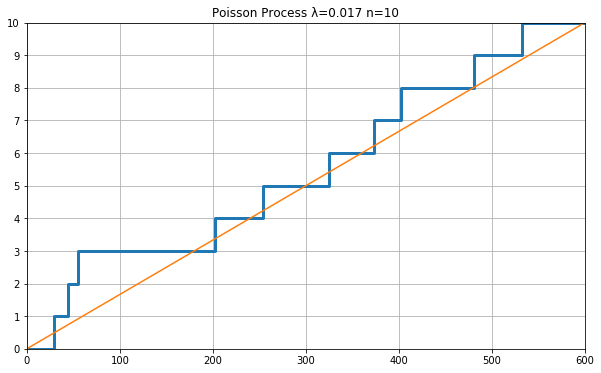

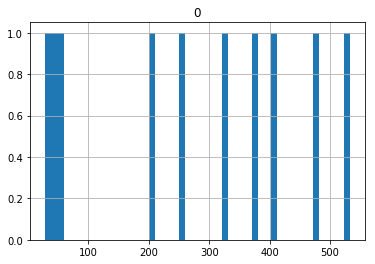

In [14]:
#Create poisson distribution for values consistency
random.seed(41)
#Assuming a Poisson-Distribution for passengers arriving at the train station
fail = PoissonDistribution(λ=1/60, N=10, plot=True)
fail = pd.DataFrame(fail) 
fail.mean()
fail.hist(bins=50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000023356EC9CF8>]],
      dtype=object)

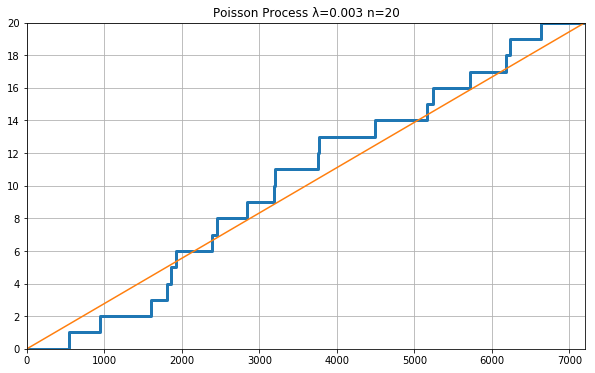

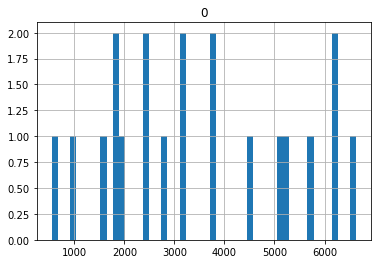

In [15]:
#Assuming a Poisson-Distribution for passengers arriving at the train station
cus = PoissonDistribution(λ=10/3600, N=20, plot=True)
cus = pd.DataFrame(cus) 
cus.mean()
cus.hist(bins=50)

## References <a class="anchor" id="10-bullet"></a>

[1] 	E. Hassannayebi, S. H. Zegordi, M. Yaghini and M. R. Amin-Naseri, "Timetable optimization models and methods for minimizing passenger waiting time at public transit terminals," Transportation Planning and Technology, vol. 40, no. 3, pp. 278-304, 2017.

[2] SimPy, "Documentation for SimPy," 2020. [Online]. Available: https://simpy.readthedocs.io/en/latest/contents.html [Accessed on: May. 10, 2020].

[3] 	W. Kim, Y. Jeon and Y. Kim, "Simulation-based optimization of an integrated daylighting and HVAC system using the design of experiments method," Applied Energy, vol. 162, no. 1, pp. 666-674, 2016.

[4] 	M. Hrušovský, E. Demir, W. Jammernegg and T. V. Woensel , "Hybrid simulation and optimization approach for green intermodal transportation problem with travel time uncertainty," Flexible Services and Manufacturing Journal, vol. 30, no. 1, p. 486–516, 2018.

[5] A.B. Downey, Modelling and Simulation in Python, 3rd ed. Needham, Massachusetts: Green Tea Press, 2017.

[6] D. Abbott, and M.V. Marinov, "An event based simulation model to evaluate the design of a rail interchange yard, which provides service to high speed and conventional railways," Simulation Modelling Practice and Theory, Vol. 52, pp.15-39, Jan. 2015.

[7] 	X. Xu, K. Li and X. Lu, "Simultaneous locomotive assignment and train scheduling on a single-track railway line: A simulation-based optimization approach," Computers & Industrial Engineering, vol. 127, no. 2, pp. 1336-1351, 2019.

[8] Pint, "Pint: makes units easy," 2020. [Online]. Available: https://pint.readthedocs.io/en/0.10.1/ [Accessed on: May. 10, 2020].

[9] BirminghamLive, "Plan to open HS2 high speed rail service in 2026 'may not be realistic," 2020. [Online]. Available: https://www.birminghammail.co.uk/news/midlands-news/plan-open-hs2-high-speed-11882357 [Accessed on: May. 10, 2020].